# Copyright (c) 2025 João Frederico Roldan Viana

# Este código está licenciado sob a Creative Commons Atribuição-NãoComercial 4.0 Internacional. Você pode copiar, modificar e distribuir este código para fins NÃO comerciais, desde que forneça a devida atribuição ao autor original.


# Contato: jfredrv@gmail.com

# **Algoritmo IGN**

## Bibliotecas

### Instalações

In [1]:
!pip install nltk
!pip install fuzzy-c-means
!pip install gdown
!pip install scikit-learn-extra
!pip install tabulate>=0.9

### Declarações

In [2]:
import gdown
import heapq
import nltk
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from nltk.corpus import reuters
from pandas import DataFrame
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist, pdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.datasets import make_moons, make_circles
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture


## Definições das Funções

### Algoritmos de Árvores

In [3]:
def kruskal(dist_matriz):
    num_vertices = dist_matriz.shape[0]
    arestas = []

    for i in range(num_vertices):
        for j in range(i+1, num_vertices):
            if dist_matriz[i, j] != 0:
                arestas.append((dist_matriz[i, j], i, j))

    arestas = sorted(arestas)
    no_pai = list(range(num_vertices))
    rank = [0] * num_vertices

    def procurar(v):
        if no_pai[v] != v:
            no_pai[v] = procurar(no_pai[v])
        return no_pai[v]

    def unir(v1, v2):
        raiz1 = procurar(v1)
        raiz2 = procurar(v2)
        if raiz1 != raiz2:
            if rank[raiz1] > rank[raiz2]:
                no_pai[raiz2] = raiz1
            elif rank[raiz1] < rank[raiz2]:
                no_pai[raiz1] = raiz2
            else:
                no_pai[raiz2] = raiz1
                rank[raiz1] += 1

    agm_arestas = []
    for peso, u, v in arestas:
        if procurar(u) != procurar(v):
            unir(u, v)
            agm_arestas.append((u, v, peso))

    agm_matriz = np.zeros_like(dist_matriz)
    for u, v, peso in agm_arestas:
        agm_matriz[u, v] = peso
        agm_matriz[v, u] = peso

    return agm_matriz

In [4]:
def prim(dist_matriz):
    num_vertices = dist_matriz.shape[0]
    selecionado = [False] * num_vertices
    min_heap = [(0, 0, -1)]  # (peso, vertice, origem)
    agm_matriz = np.zeros_like(dist_matriz)

    while min_heap:
        peso, u, origem = heapq.heappop(min_heap)
        if selecionado[u]:
            continue
        selecionado[u] = True
        if origem != -1:
            agm_matriz[origem, u] = peso
            agm_matriz[u, origem] = peso
        for v in range(num_vertices):
            if dist_matriz[u, v] != 0 and not selecionado[v]:
                heapq.heappush(min_heap, (dist_matriz[u, v], v, u))

    return agm_matriz

### Funções de exibição

In [5]:
def plot_pontos(df, target=None):
    plt.figure(figsize=(14, 8))
    if target is not None:
      plt.scatter(df['x'], df['y'], c=target, cmap='cividis')
    else:
      plt.scatter(df['x'], df['y'], color='green')
    plt.title('Pontos Gerados - ' + df.titulo)
    plt.show()

In [6]:
def plot_pts_agm(df, components):
    pos = {i: (df.values[i, 0], df.values[i, 1]) for i in range(len(df))}

    plt.figure(figsize=(14, 8))

    # Definindo cores para os componentes
    cores = plt.cm.rainbow(np.linspace(0, 1, max(len(set(components)), max(components) + 1)))

    # Plotando os pontos com cores baseadas nos componentes
    for component_id in set(components):
        nodes = [i for i in range(len(components)) if components[i] == component_id]
        plt.scatter(df.values[nodes, 0], df.values[nodes, 1], color=cores[component_id], s=100, zorder=2, label=f'Grupo {component_id+1}')

    plt.title('Algoritmo IGN - ' + df.titulo)
    plt.show()

    print("\nQuantidade de elementos em cada grupo (components):")
    component_counts = {component: count for component, count in zip(*np.unique(components, return_counts=True))}
    for component, count in component_counts.items():
      print(f"Grupo {component}: {count} elementos")

In [7]:
def plot_pontos3D(df, target=None):
  x = df.iloc[:, 0]
  y = df.iloc[:, 1]
  z = df.iloc[:, 2]

  # Criar o gráfico 3D
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(111, projection='3d')

  # Plotar os pontos no gráfico 3D
  if target is not None:
        # Contar a quantidade por grupo
        unique_groups, counts = np.unique(target, return_counts=True)
        group_counts = {group: count for group, count in zip(unique_groups, counts)}

        # Fazer os prints das quantidades
        print("Quantidade por grupo:")
        for group, count in group_counts.items():
            print(f"Grupo {group}: {count} elementos")
        scatter = ax.scatter(x, y, z, c=target, cmap='cividis', alpha=0.8, s=50, zorder=2)
  else:
    scatter = ax.scatter(x, y, z, c='green', alpha=0.8, s=50, zorder=2)

  # Adicionar rótulos e título
  ax.set_title(getattr(df, 'titulo', 'Scatter 3D'))
  ax.set_xlabel(df.columns[0])
  ax.set_ylabel(df.columns[1])
  ax.set_zlabel(df.columns[2])

  # Exibir o gráfico
  plt.show()

In [8]:
def plot_pts_agm3D(df, components, algoritmo='IGN'):
    # Criar o gráfico 3D
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Definindo cores para os componentes
    # Change: Extend the colors array to handle extra components
    cores = plt.cm.prism(np.linspace(0, 1, max(len(set(components)), max(components) + 1)))

    # Plotando os pontos com cores baseadas nos componentes
    for component_id in set(components):
        nodes = [i for i in range(len(components)) if components[i] == component_id]
        x = df.values[nodes, 0]
        y = df.values[nodes, 1]
        z = df.values[nodes, 2]
        # Corrigindo o argumento de cores
        ax.scatter(x, y, z, c=[cores[component_id]], alpha=0.8, s=50, zorder=2,
                   label=f'Grupo {component_id+1}')

    # Adicionando título e rótulos
    ax.set_title('Algoritmo ' + algoritmo + ' - ' + df.titulo)
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    ax.set_zlabel(df.columns[2])

    plt.show()

    # Fazer os prints das quantidades
    print("\nQuantidade de elementos em cada grupo (components):")
    component_counts = {component: count for component, count in zip(*np.unique(components, return_counts=True))}
    for component, count in component_counts.items():
      print(f"Grupo {component}: {count} elementos")

In [9]:
def plot_custo_vs_n(custos, rotulo):
    n_val = [item['n'] for item in custos]
    custo_val = [item['agm_custo'] for item in custos]
    plt.figure(figsize=(18, 6))
    plt.plot(n_val, custo_val)
    plt.xlabel('Número de arestas removidas')
    plt.ylabel('Custo da Árvore Geradora Mínima')
    plt.title('Variação do Custo da Árvore Geradora Mínima com Remoção de Arestas - ' + rotulo)
    plt.grid(True)
    plt.xticks(n_val[::5])
    plt.show()

In [10]:
def print_agm_custo(agm_custo, n):
    print()
    print("Custo da Árvore Geradora Mínima:", agm_custo)
    print()
    print("Grupos identificados:", n)
    print()

### IGN

In [11]:
def ign(df, metrica='euclidean', arvore=None, plot_custo=True,
        min_grupo=None, max_grupo=None, plotAGM='2D'):

    agmTotal = arvore_geradora_minima(df, metrica, arvore)
    agmOriginal = agmTotal.copy()
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término da geração da Árvore Geradora Mínima")

    arestas = arestas_ordenadas(agmTotal)
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término da geração das arestas")

    # Definir limites
    if min_grupo is None:
        min_grupo = 1
    if max_grupo is None:
        max_grupo = len(df)-1

    # Salvar custos {n, agm_custo}
    custos = calcula_custos(agmTotal, arestas)
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término do cálculo do custo")

    # Criando a estrutura para armazenar a diferença de custo
    difCusto = []
    for i in range(len(df)-2):
        dif1 = custos[i]['agm_custo'] - custos[i+1]['agm_custo']
        dif2 = custos[i+1]['agm_custo'] - custos[i+2]['agm_custo']
        dif = abs(dif1 - dif2)
        difCusto.append({'n': i, 'difCusto': dif})

    n_alvo= min(
        (i for i in range(1, len(difCusto))
        if min_grupo <= difCusto[i]['n'] <= max_grupo),
        key=lambda i: difCusto[i]['difCusto'] - difCusto[i-1]['difCusto'])

    # Chamando a função para calcular a árvore geradora mínima
    # dos grupos identificados
    agm, agm_custo, grupos = arvore_modificada(df, n_alvo, agmOriginal, arestas)

    # Plotando o resultado final
    if plotAGM == '2D':
      plot_pts_agm(df, grupos)
    else:
      plot_pts_agm3D(df, grupos)

    # Imprimindo o gráfico de custos
    if plot_custo:
        plot_custo_vs_n(custos, df.titulo)

    # Imprimindo o resultado
    distinct_groups = np.unique(grupos)
    num_groups = len(distinct_groups)
    print_agm_custo(agm_custo, num_groups)

    return grupos

In [12]:
def arvore_geradora_minima(df, metrica='euclidean', arvore=None):
    print(f"{datetime.now().strftime('%H:%M:%S')} - Início do cálculo da matriz de distancias")
    dist_matriz = cdist(df.values, df.values, metric=metrica)
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término do cálculo da matriz de distancias")
    if arvore is None:
        return minimum_spanning_tree(dist_matriz).toarray().astype(float)
    elif arvore == 'kruskal':
        return kruskal(dist_matriz)
    elif arvore == 'prim':
        return prim(dist_matriz)
    else:
        raise ValueError("Método deve ser 'kruskal', 'prim' ou nenhum")

In [13]:
def arestas_ordenadas(agm):
    # Convertendo a matriz de adjacência para uma lista de arestas
    arestas = []
    for i in range(len(agm)):
        for j in range(i + 1, len(agm)):
            if agm[i, j] > 0:
                arestas.append((i, j, agm[i, j]))

    # Ordenando as arestas por peso em ordem decrescente
    return sorted(arestas, key=lambda x: x[2], reverse=True)

In [14]:
def calcula_custos(agm, arestas_sorted):
    # Inicializando a lista para salvar os pares {n, agm_custo}
    custos = []
    n = len(agm)
    custoTotal = np.sum(agm[agm > 0])

    # Removendo as n maiores arestas
    for i in range(n):
        custos.append({'n': i, 'agm_custo': custoTotal})
        if i < n - 1:
          u, v, w = arestas_sorted[i]
          val1 = agm[u, v] if agm[u, v] > 0 else agm[u, v] * (-1)
          val2 = agm[v, u] if agm[v, u] > 0 else agm[v, u] * (-1)
          custoTotal = custoTotal - val1 - val2
          agm[u, v] = 0
          agm[v, u] = 0

    return custos

In [15]:
def arvore_modificada(df, n, agm, arestas_sorted):

    # Removendo as n maiores arestas
    for i in range(n):
        u, v, w = arestas_sorted[i]
        agm[u, v] = 0
        agm[v, u] = 0

    # Identificando os componentes conectados
    def dfs(node, component_id):
        stack = [node]
        while stack:
            u = stack.pop()
            if components[u] == -1:
                components[u] = component_id
                for v in range(len(agm)):
                    if agm[u, v] > 0 or agm[v, u] > 0:
                        stack.append(v)

    components = [-1] * len(df)
    component_id = 0
    for i in range(len(df)):
        if components[i] == -1:
            dfs(i, component_id)
            component_id += 1

    # Calculando o custo da árvore geradora mínima
    agm_custo = np.sum(agm[agm > 0])

    return agm, agm_custo, components

### IGN com percentual de grupo

In [16]:
def ignModificado(df, metrica='euclidean', arvore=None, plot_custo=True,
        min_grupo=None, max_grupo=None, plotAGM='2D', percGrupo=None):

    if percGrupo is not None and (percGrupo <= 0.5 or percGrupo >= 1):
        raise ValueError("Parâmetro percGrupo deve ser maior que 0.5 e menor que 1")

    # Chamando a função para calcular a árvore geradora mínima
    # dos grupos identificados
    agm, agm_custo, grupos, custos, n_alvo = ignBase(df, metrica, arvore, min_grupo, max_grupo)

    # Caso tenha parâmetro de percentual por grupo
    if percGrupo is not None:
        grupos = list(grupos)
        total_elementos = len(df)
        print('total_elementos: ', total_elementos)
        max_grupo_id = max(grupos)

        while True:
            grupos_counter = Counter(grupos)
            print('grupos_counter: ', grupos_counter)

            # Verificar se algum grupo excede percGrupo * len(df)
            encontrou_grupo_grande = False
            for grupo, tamanho in grupos_counter.items():
                if tamanho >= percGrupo * total_elementos:
                    encontrou_grupo_grande = True
                    print('grupo: ', grupo)
                    print('tamanho: ', tamanho)

                    # Filtrar o dataframe para os elementos desse grupo
                    elementos_grupo = [i for i, g in enumerate(grupos) if g == grupo]
                    df_grupo = df.iloc[elementos_grupo]

                    # Chamar ignBase para o subconjunto
                    _, _, subgrupos, _, _ = ignBase(df_grupo, metrica, arvore, min_grupo, max_grupo)
                    subgrupos = list(subgrupos)

                    # Atualizar os grupos originais com os novos agrupamentos
                    novo_grupo_base = max_grupo_id + 1
                    for idx, subgrupo in zip(elementos_grupo, subgrupos):
                        grupos[idx] = novo_grupo_base + subgrupo

                    # Atualizar o valor máximo do grupo
                    max_grupo_id = max(grupos)

                    # Recomeçar a verificação dos grupos
                    break
            if not encontrou_grupo_grande:
                # Sair do laço se nenhum grupo exceder o tamanho percGrupo * len(df)
                break

    # Plotando o resultado final
    if plotAGM == '2D':
        plot_pts_agm(df, grupos)
    else:
        plot_pts_agm3D(df, grupos)

    # Imprimindo o gráfico de custos
    if plot_custo:
        plot_custo_vs_n(custos, df.titulo)

    # Imprimindo o resultado
    distinct_groups = np.unique(grupos)
    num_groups = len(distinct_groups)
    print_agm_custo(agm_custo, num_groups)

    return grupos

In [17]:
def ignBase(df, metrica='euclidean', arvore=None, min_grupo=None, max_grupo=None):

    agmTotal = arvore_geradora_minima(df, metrica, arvore)
    agmOriginal = agmTotal.copy()
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término da geração da Árvore Geradora Mínima")

    arestas = arestas_ordenadas(agmTotal)
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término da geração das arestas")

    # Definir limites
    if min_grupo is None:
        min_grupo = 1
    if max_grupo is None:
        max_grupo = len(df)-1

    # Salvar custos {n, agm_custo}
    custos = calcula_custos(agmTotal, arestas)
    print(f"{datetime.now().strftime('%H:%M:%S')} - Término do cálculo do custo")

    # Criando a estrutura para armazenar a diferença de custo
    difCusto = []
    for i in range(len(df)-2):
        dif1 = custos[i]['agm_custo'] - custos[i+1]['agm_custo']
        dif2 = custos[i+1]['agm_custo'] - custos[i+2]['agm_custo']
        dif = abs(dif1 - dif2)
        difCusto.append({'n': i, 'difCusto': dif})

    n_alvo= min(
        (i for i in range(1, len(difCusto))
        if min_grupo <= difCusto[i]['n'] <= max_grupo),
        key=lambda i: difCusto[i]['difCusto'] - difCusto[i-1]['difCusto'])
    print('n_alvo: ', n_alvo)

    # Chamando a função para calcular a árvore geradora mínima
    # dos grupos identificados
    agm, agm_custo, grupos = arvore_modificada(df, n_alvo, agmOriginal, arestas)
    return agm, agm_custo, grupos, custos, n_alvo

## Datasets Devillez

### Datasets Devillez - Definição

#### Amostra Devillez - 3 grupos

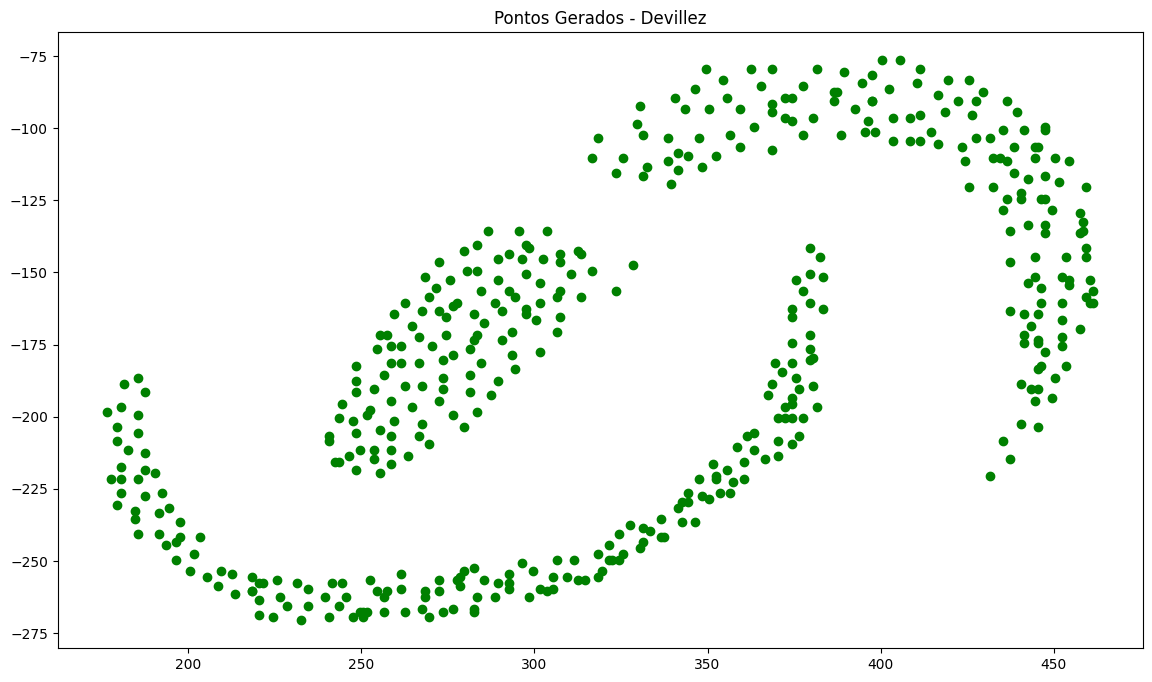

In [18]:
# Definindo uma amostra de Devillez
csv_url = 'https://drive.google.com/uc?id=1VQAgkhmz2f2COV9jZhG-PPMyZo1nYR-E'
dfDevillez3 = pd.read_csv(csv_url, sep=';', header=None, names=['x', 'y'])

setattr(dfDevillez3, 'titulo', 'Devillez')

# Plotando os pontos gerados
plot_pontos(dfDevillez3)

#### Amostra Devillez - 4 grupos

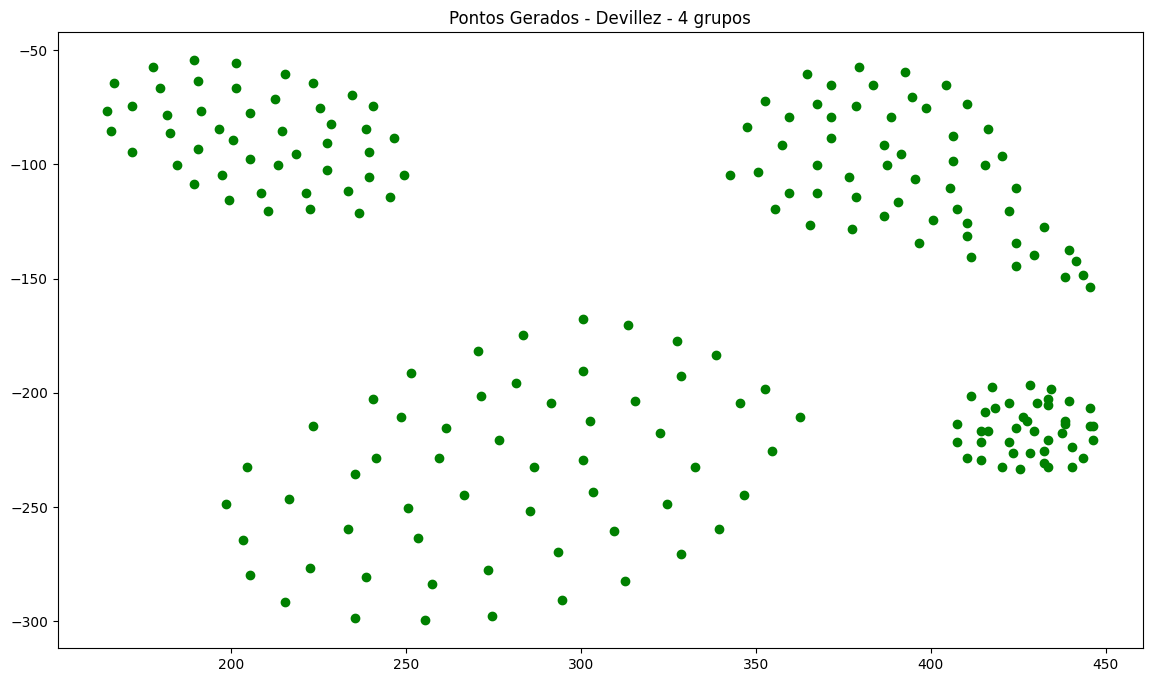

In [19]:
# Definindo uma amostra de Devillez
csv_url = 'https://drive.google.com/uc?id=1fU4F4rNFVkJQ-BxbXHVFRY1hNn6Tq6c-'
dfDevillez4 = pd.read_csv(csv_url, sep=';', header=None, names=['x', 'y'])

setattr(dfDevillez4, 'titulo', 'Devillez - 4 grupos')

# Plotando os pontos gerados
plot_pontos(dfDevillez4)

### Datasets Devillez - IGN

#### IGN - Datasets Originais (Distância: euclidean e Árvore: minimum_spanning_tree)



##### Amostra Devillez - 3 grupos

17:48:15 - Início do cálculo da matriz de distancias
17:48:15 - Término do cálculo da matriz de distancias
17:48:15 - Término da geração da Árvore Geradora Mínima
17:48:15 - Término da geração das arestas
17:48:15 - Término do cálculo do custo


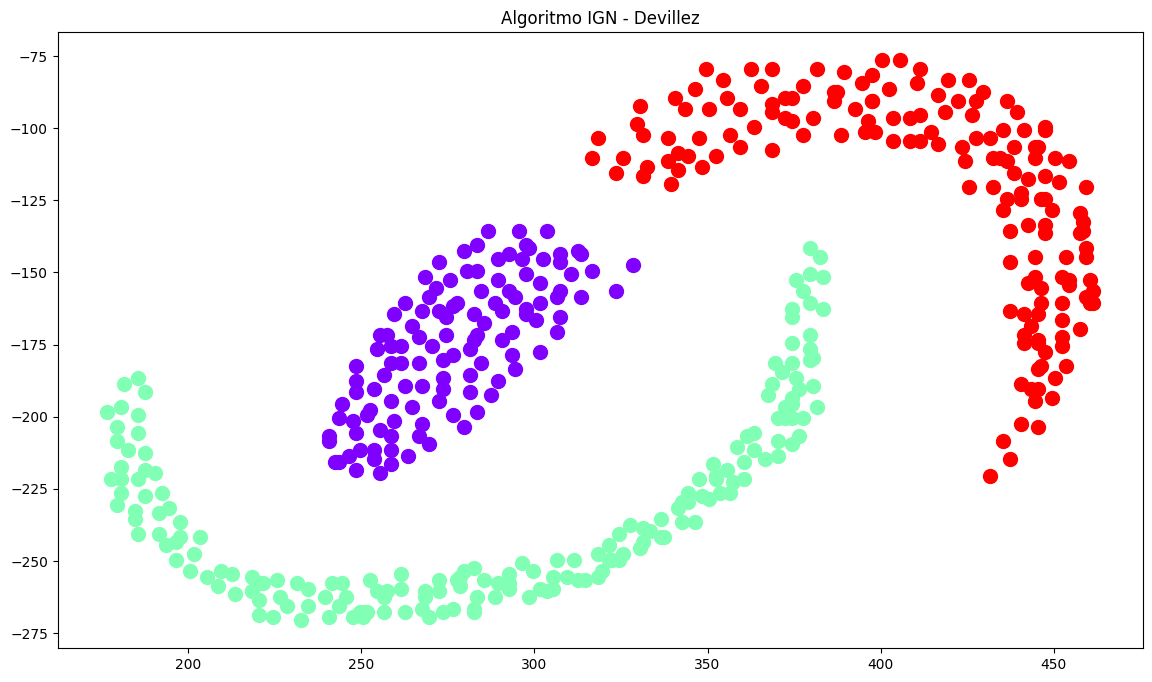


Quantidade de elementos em cada grupo (components):
Grupo 0: 119 elementos
Grupo 1: 183 elementos
Grupo 2: 163 elementos


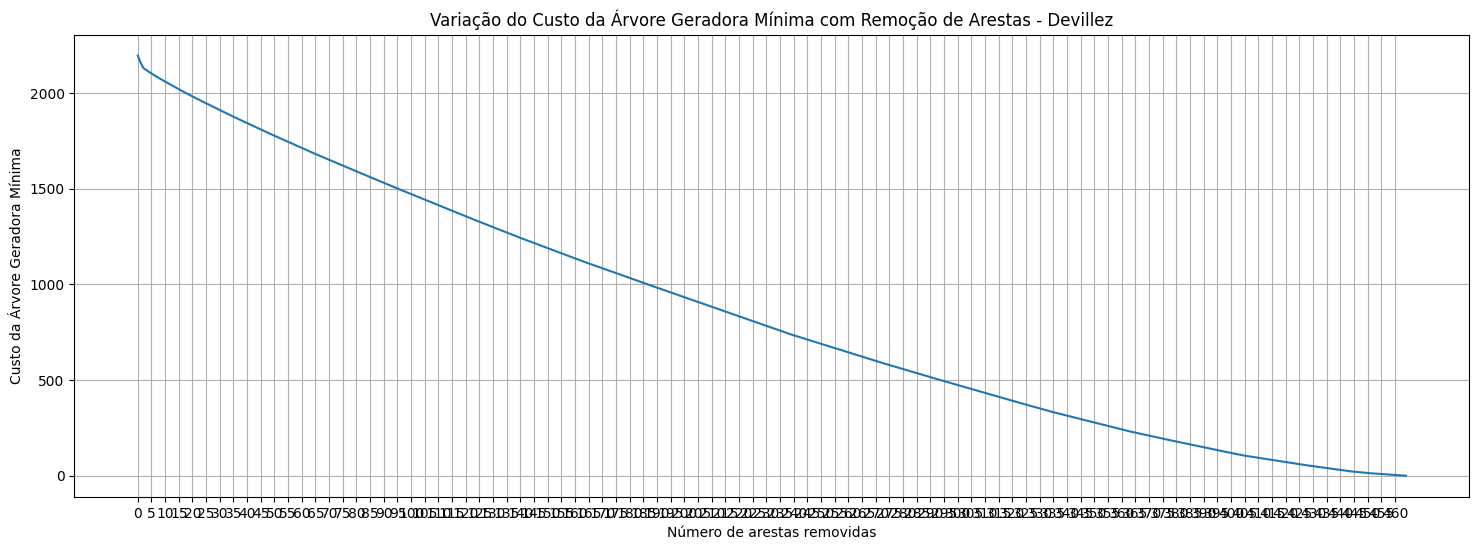


Custo da Árvore Geradora Mínima: 2132.502456137022

Grupos identificados: 3

Tempo de execução: 2.0056815147399902 segundos


In [20]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(dfDevillez3)

t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

##### Amostra Devillez - 4 grupos

17:48:17 - Início do cálculo da matriz de distancias
17:48:17 - Término do cálculo da matriz de distancias
17:48:17 - Término da geração da Árvore Geradora Mínima
17:48:17 - Término da geração das arestas
17:48:17 - Término do cálculo do custo


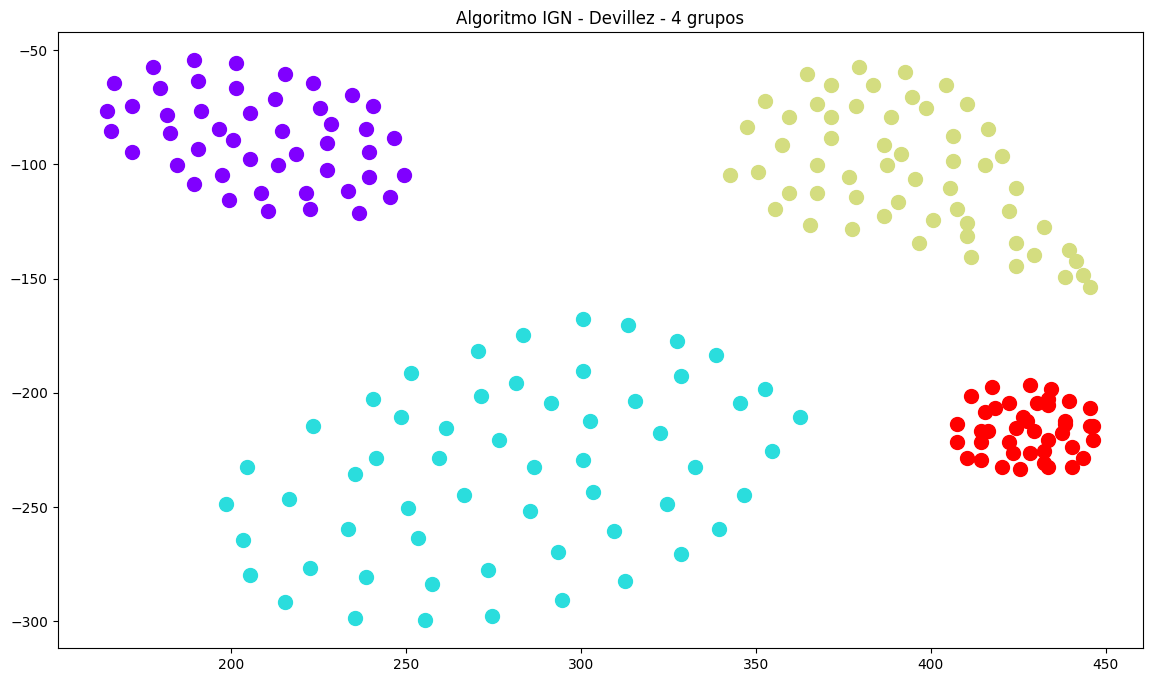


Quantidade de elementos em cada grupo (components):
Grupo 0: 47 elementos
Grupo 1: 57 elementos
Grupo 2: 57 elementos
Grupo 3: 41 elementos


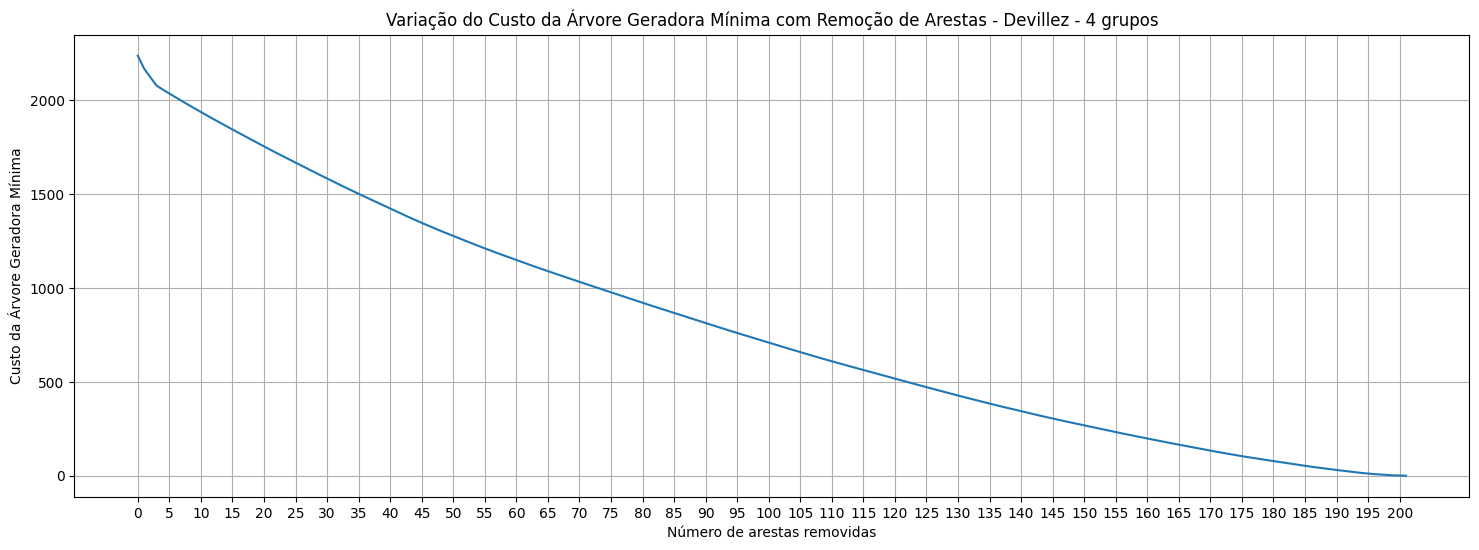


Custo da Árvore Geradora Mínima: 2078.0598564278403

Grupos identificados: 4

Tempo de execução: 1.7768054008483887 segundos


In [21]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(dfDevillez4)

t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### IGN Modificado - Datasets Originais (Distância: euclidean e Árvore: minimum_spanning_tree)



##### Amostra Devillez - 3 grupos

17:48:19 - Início do cálculo da matriz de distancias
17:48:19 - Término do cálculo da matriz de distancias
17:48:19 - Término da geração da Árvore Geradora Mínima
17:48:19 - Término da geração das arestas
17:48:19 - Término do cálculo do custo
n_alvo:  2
total_elementos:  465
grupos_counter:  Counter({1: 183, 2: 163, 0: 119})


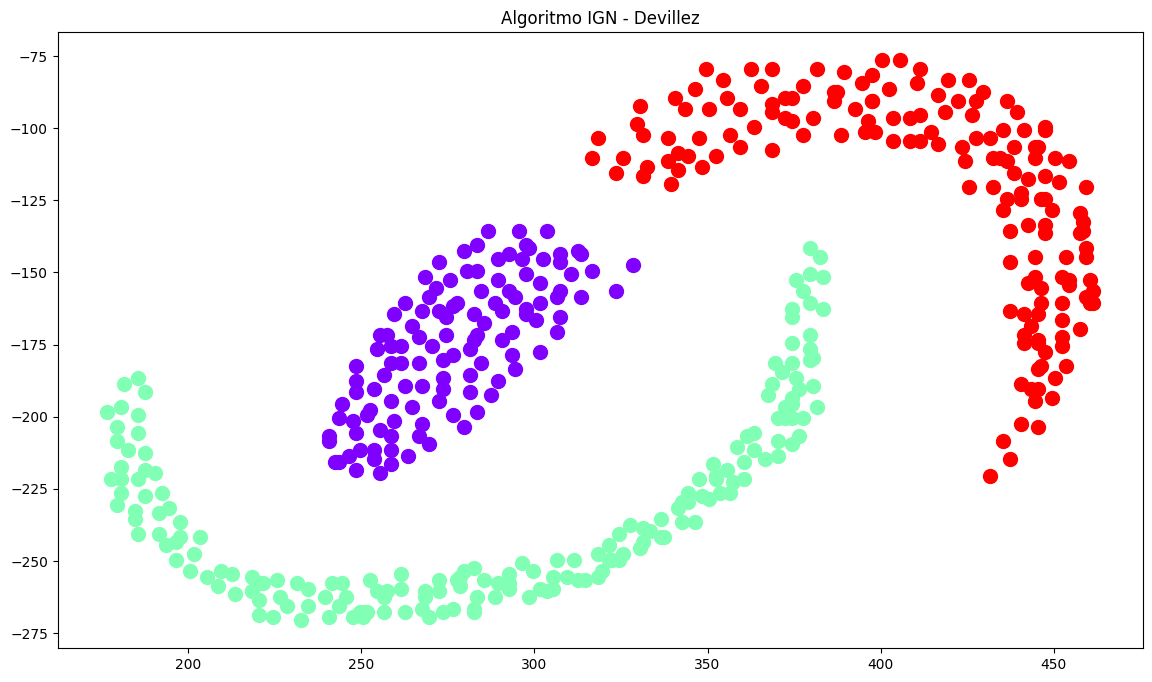


Quantidade de elementos em cada grupo (components):
Grupo 0: 119 elementos
Grupo 1: 183 elementos
Grupo 2: 163 elementos


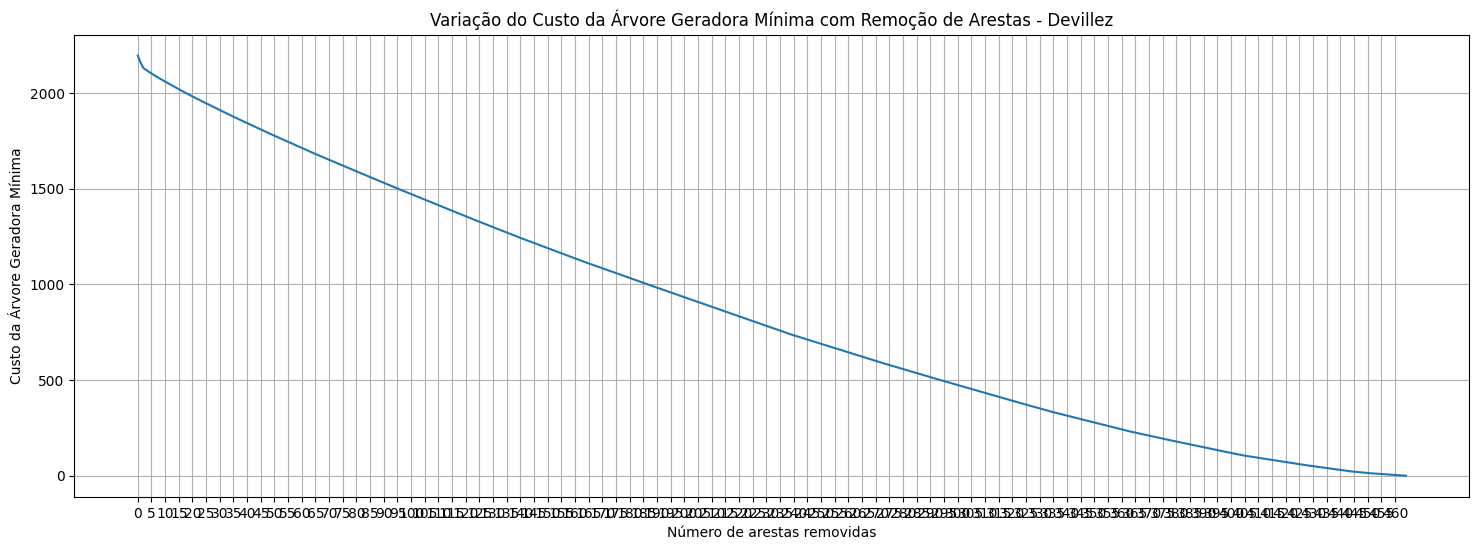


Custo da Árvore Geradora Mínima: 2132.502456137022

Grupos identificados: 3

Tempo de execução: 3.254894495010376 segundos


In [22]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(dfDevillez3, percGrupo=0.6)

t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

##### Amostra Devillez - 4 grupos

17:48:22 - Início do cálculo da matriz de distancias
17:48:22 - Término do cálculo da matriz de distancias
17:48:22 - Término da geração da Árvore Geradora Mínima
17:48:22 - Término da geração das arestas
17:48:22 - Término do cálculo do custo
n_alvo:  3
total_elementos:  202
grupos_counter:  Counter({1: 57, 2: 57, 0: 47, 3: 41})


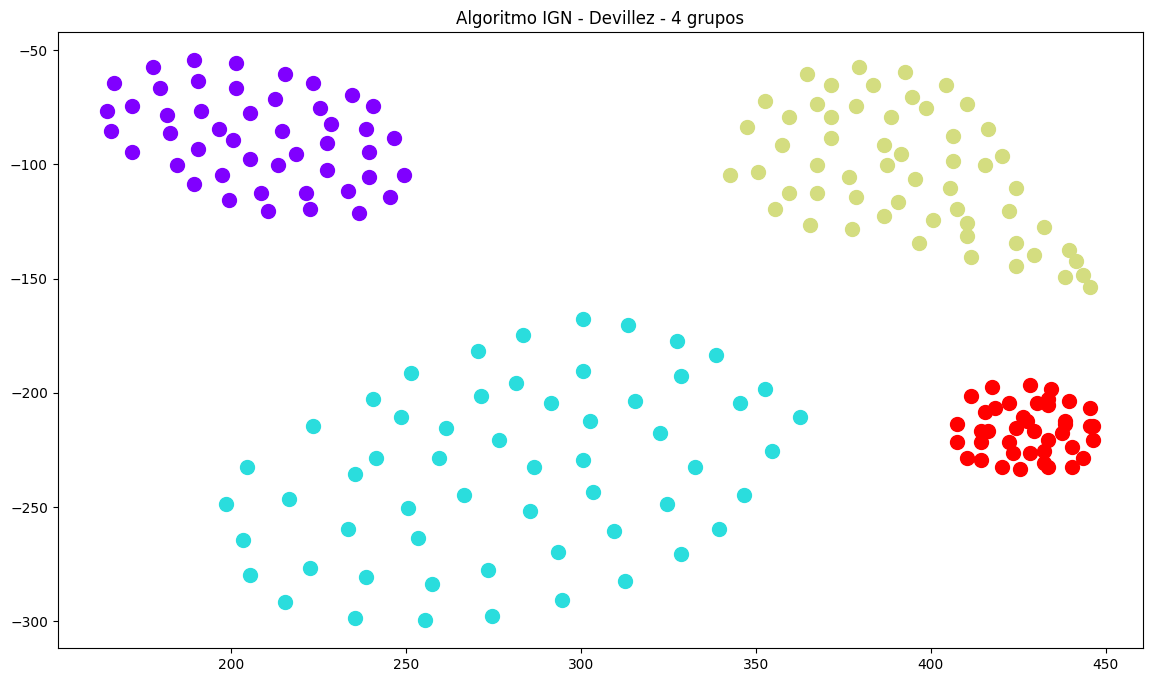


Quantidade de elementos em cada grupo (components):
Grupo 0: 47 elementos
Grupo 1: 57 elementos
Grupo 2: 57 elementos
Grupo 3: 41 elementos


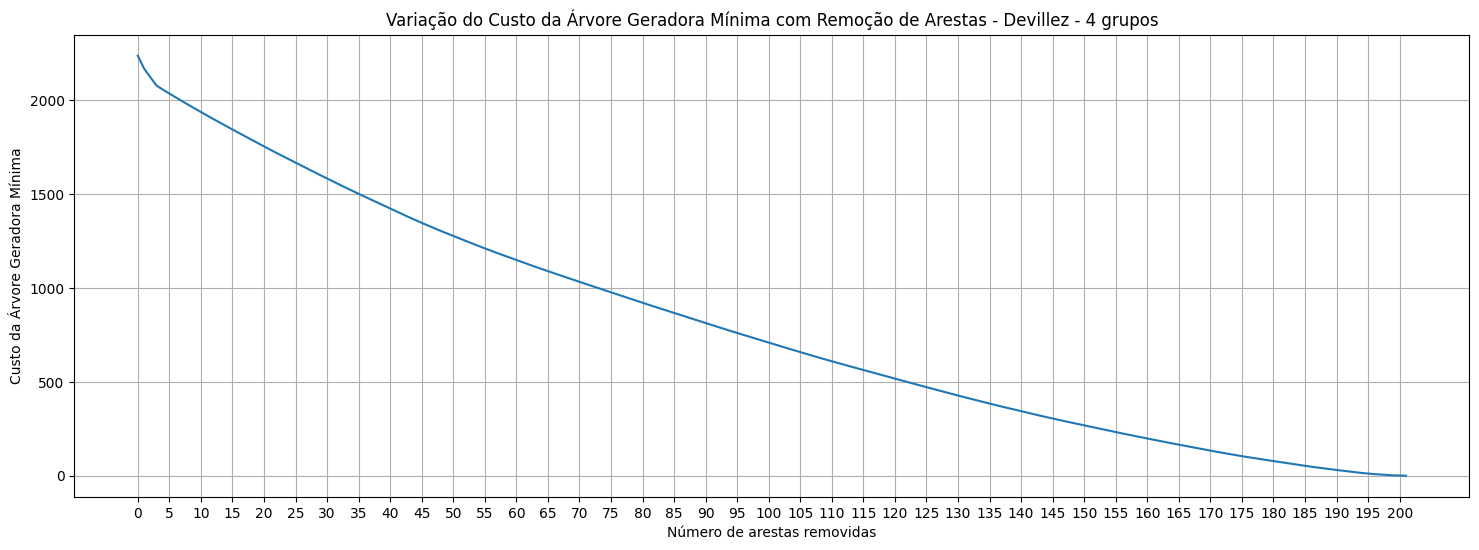


Custo da Árvore Geradora Mínima: 2078.0598564278403

Grupos identificados: 4

Tempo de execução: 1.6106150150299072 segundos


In [23]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(dfDevillez4, percGrupo=0.6)

t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

## Dados Sintéticos

### Datasets Sintéticos - Definição

#### Amostra com duas meias-luas intercaladas

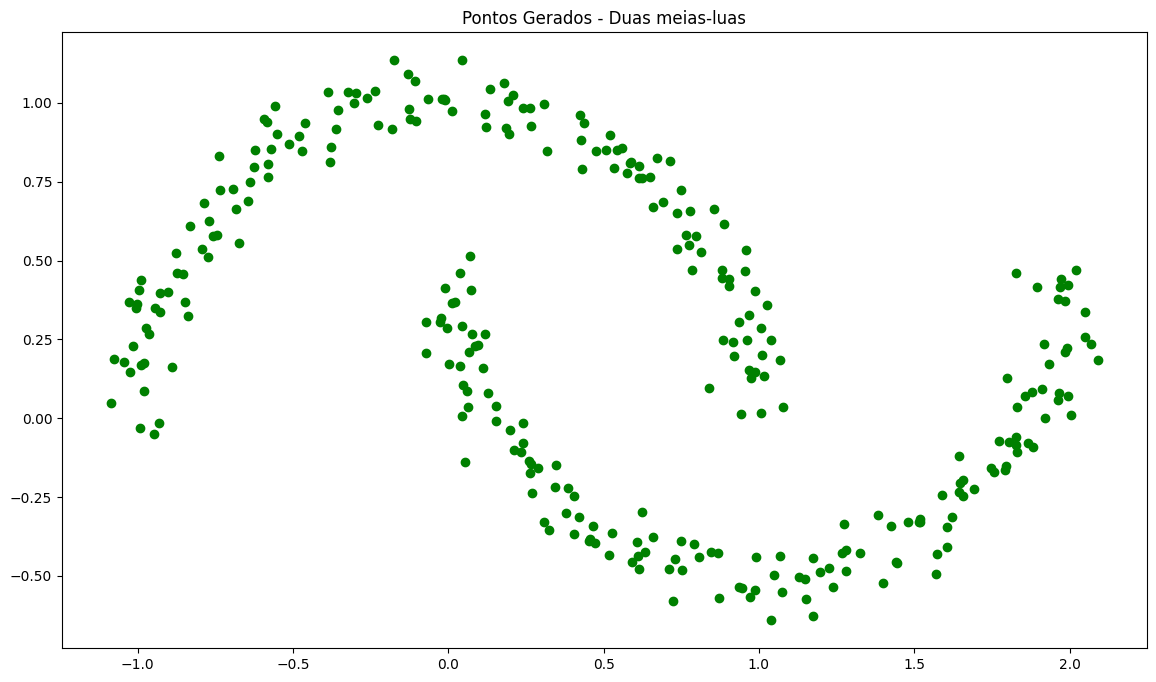

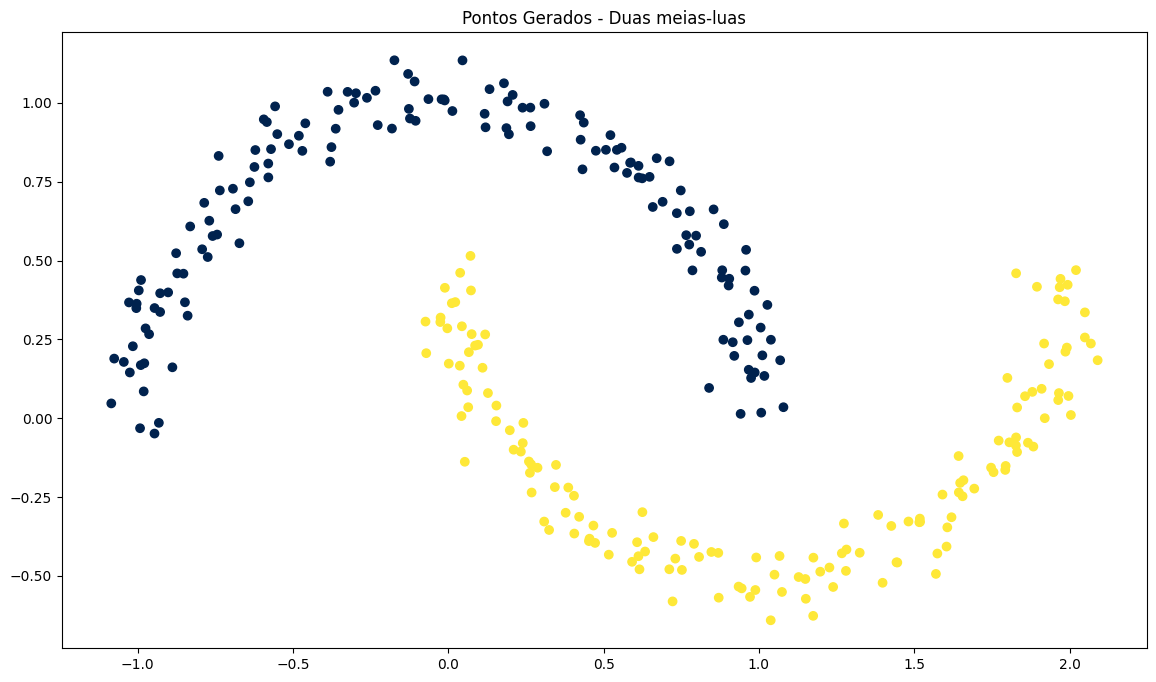

In [24]:
# Definindo uma amostra com duas meias-luas intercaladas
tam = 300

# Gerando dados aleatórios para o exemplo
elementos_moons, classes_moons = make_moons(n_samples=tam, noise=0.06, random_state=5)
df_moons = DataFrame(dict(x=elementos_moons[:,0], y=elementos_moons[:,1], classe=classes_moons))
setattr(df_moons, 'titulo', 'Duas meias-luas')

# Plotando os pontos gerados
plot_pontos(df_moons)
# Plotando os grupos esperados
plot_pontos(df_moons, classes_moons)

#### Amostra com dois circulos concêntricos

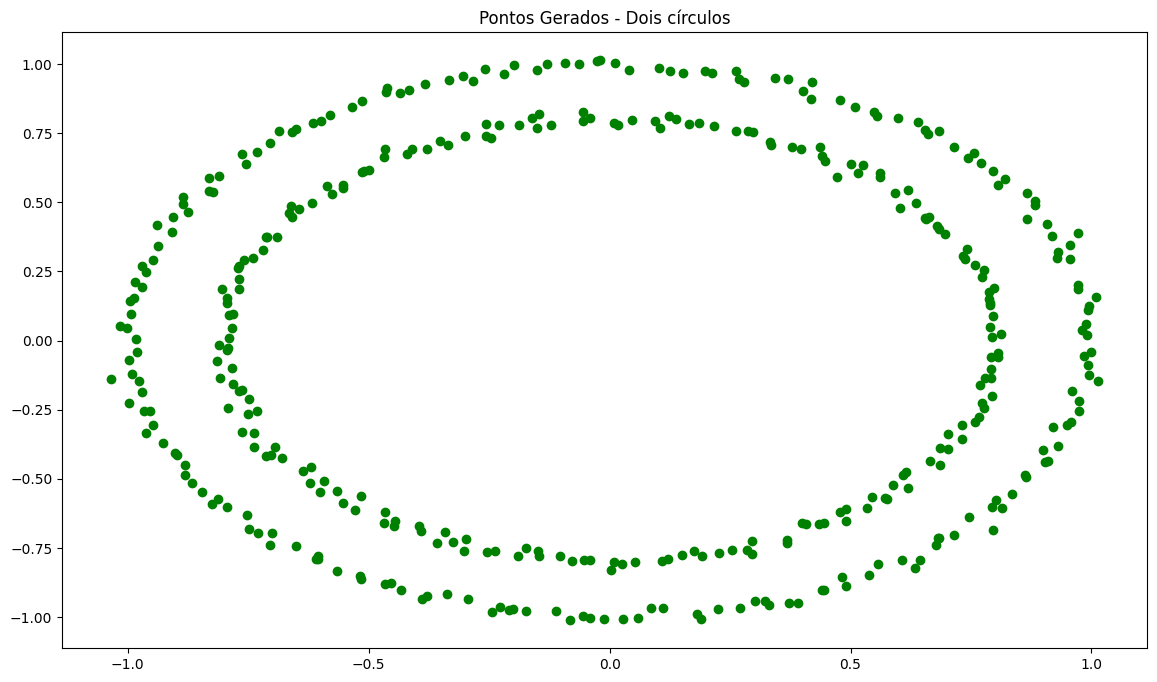

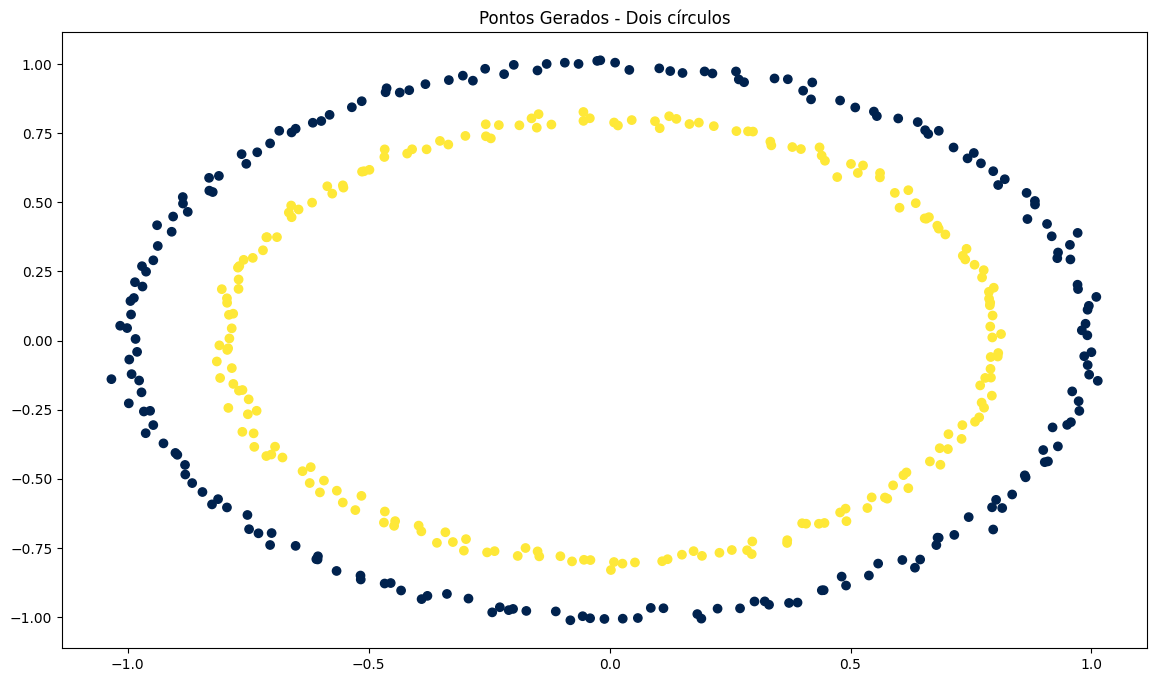

In [25]:
# Definindo uma amostra com dois circulos concentricos
tam = 400

# Gerando dados aleatórios para o exemplo
elementos_circles, classes_circles = make_circles(n_samples=tam, noise=0.015,random_state=1)
df_circles = DataFrame(dict(x=elementos_circles[:,0], y=elementos_circles[:,1], classe=classes_circles))
setattr(df_circles, 'titulo', 'Dois círculos')

# Plotando os pontos gerados
plot_pontos(df_circles)
# Plotando os grupos esperados
plot_pontos(df_circles, classes_circles)

#### Amostra com duas classes

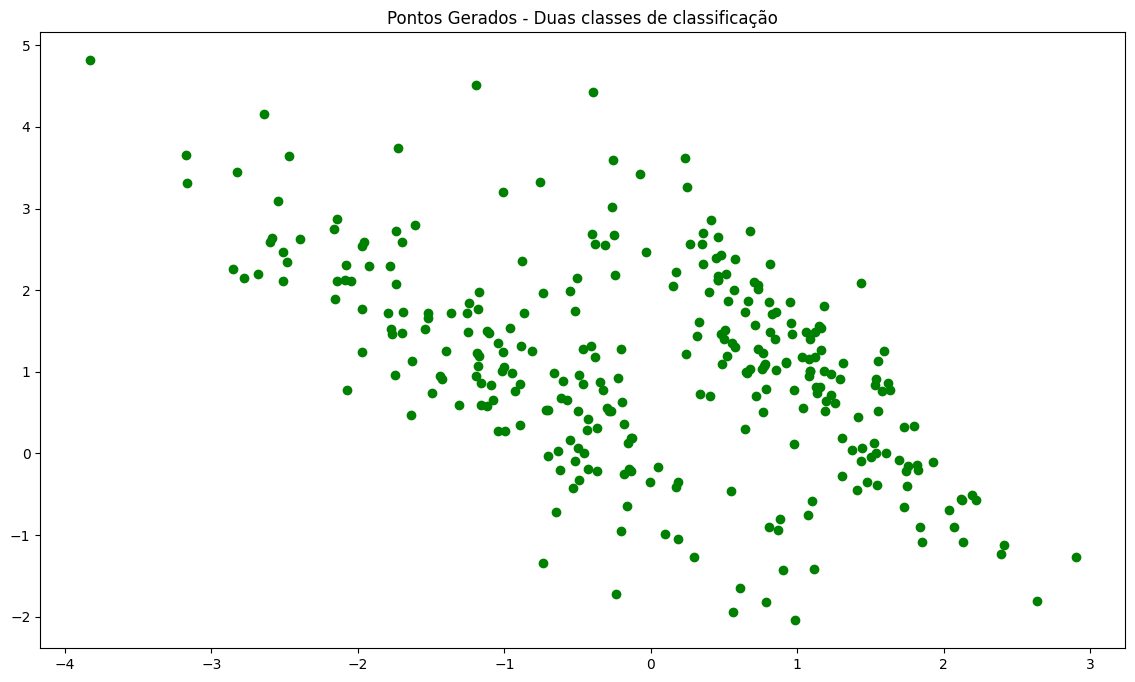

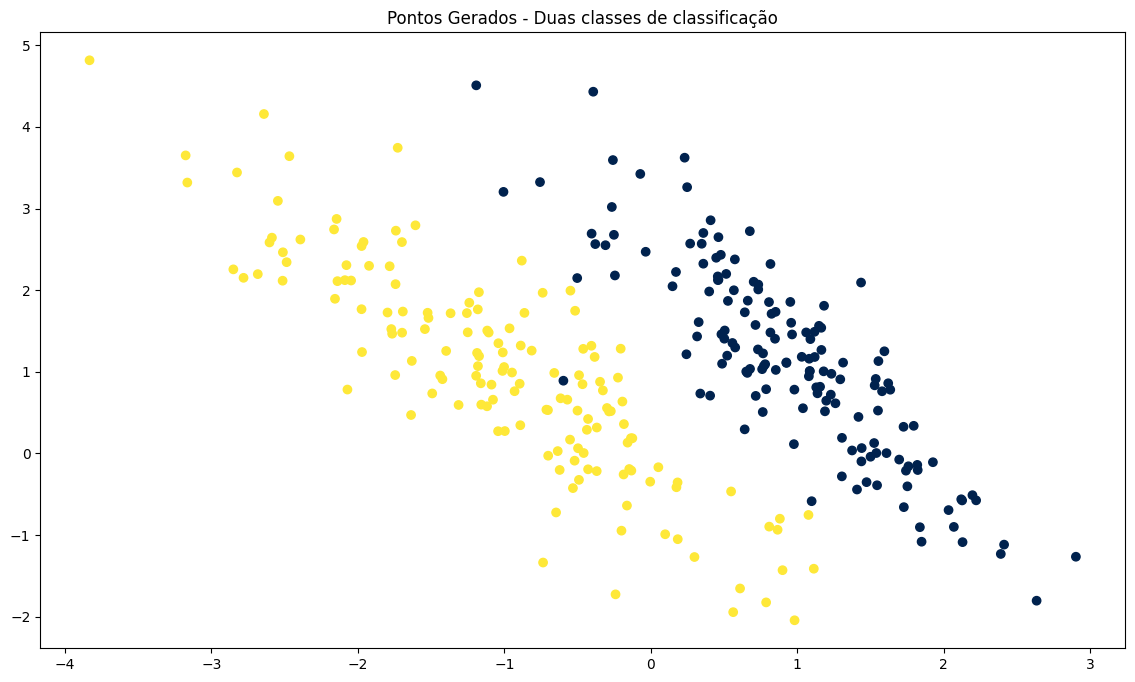

In [26]:
# Definindo uma amostra de classificação
tam = 300

# Gerando dados aleatórios para o exemplo
elementos_classification, classes_classification = make_classification(n_samples=tam, n_features=2, n_clusters_per_class=1, random_state=3, n_informative=2, n_redundant=0)
df_classification = DataFrame(dict(x=elementos_classification[:,0], y=elementos_classification[:,1], classe=classes_classification))
setattr(df_classification, 'titulo', 'Duas classes de classificação')

# Plotando os pontos gerados
plot_pontos(df_classification)
# Plotando os grupos esperados
plot_pontos(df_classification, classes_classification)

#### Amostra com dois centróides

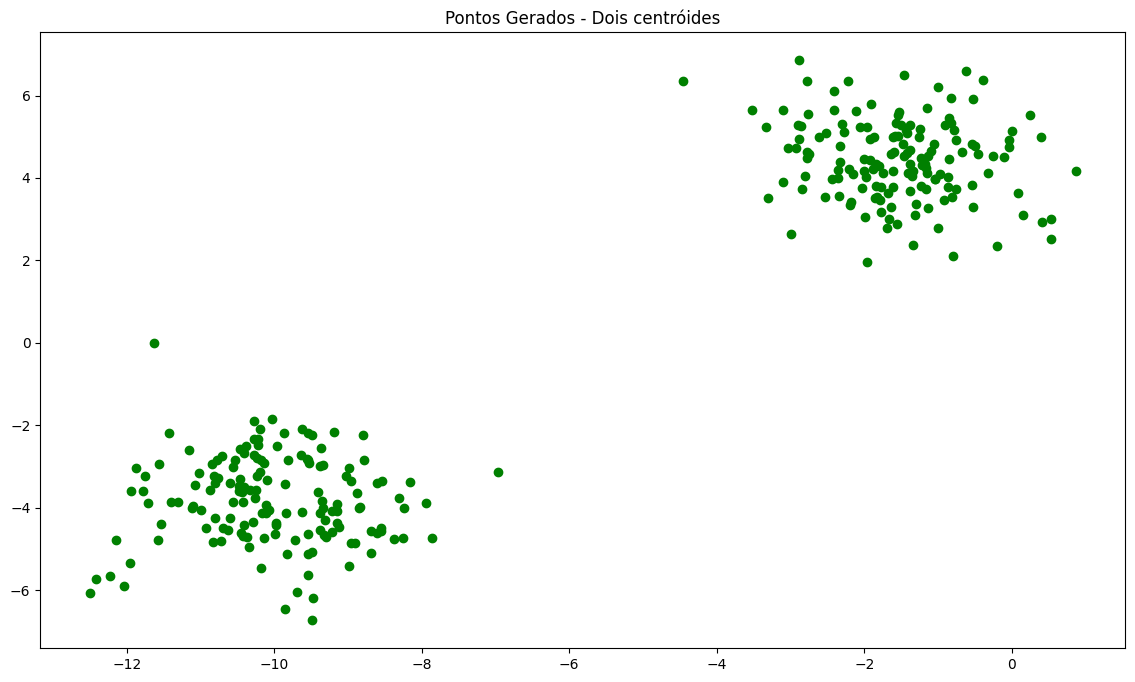

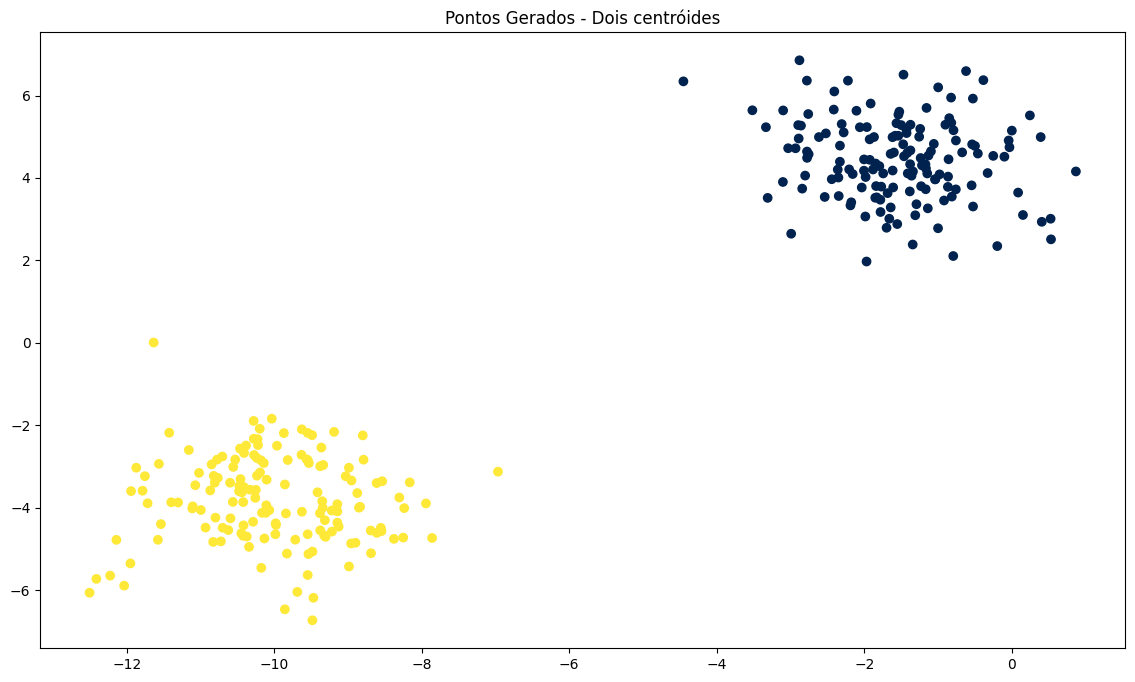

In [27]:
# Definindo uma amostra com dois centróides
tam = 300

# Gerando dados aleatórios para o exemplo
elementos_blobs, classes_blobs = make_blobs(n_samples=tam, centers=2, random_state=1)
df_blobs = DataFrame(dict(x=elementos_blobs[:,0], y=elementos_blobs[:,1], classe=classes_blobs))
setattr(df_blobs, 'titulo', 'Dois centróides')

# Plotando os pontos gerados
plot_pontos(df_blobs)
# Plotando os grupos esperados
plot_pontos(df_blobs, classes_blobs)

#### Amostra com três centróides

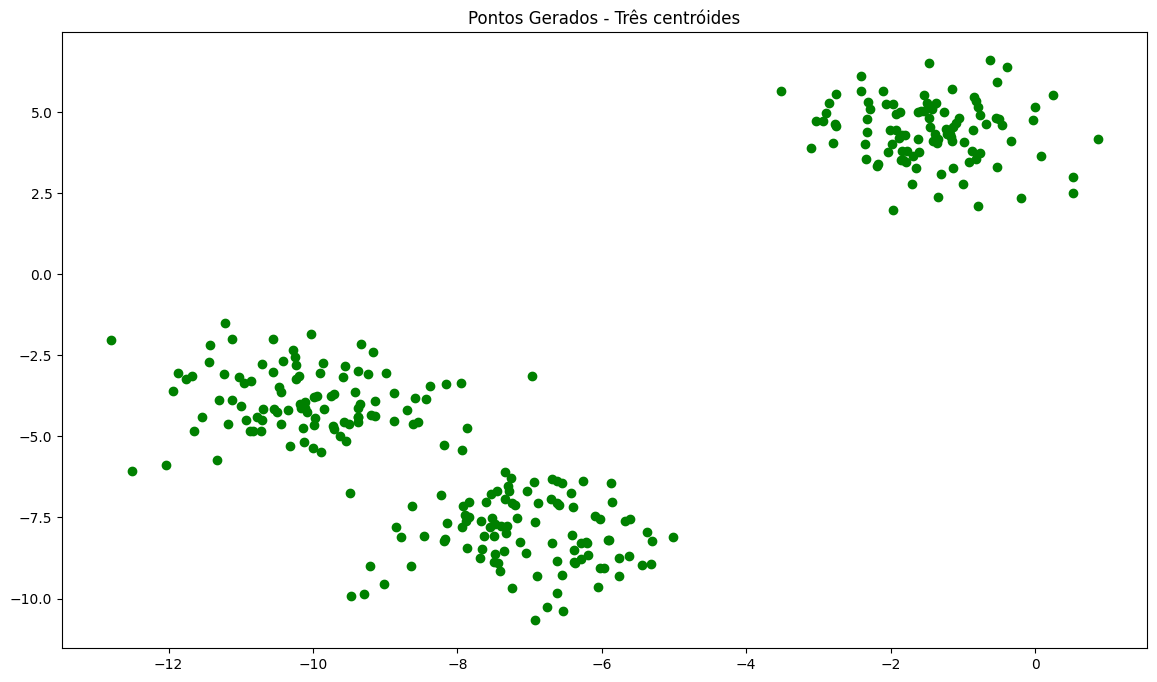

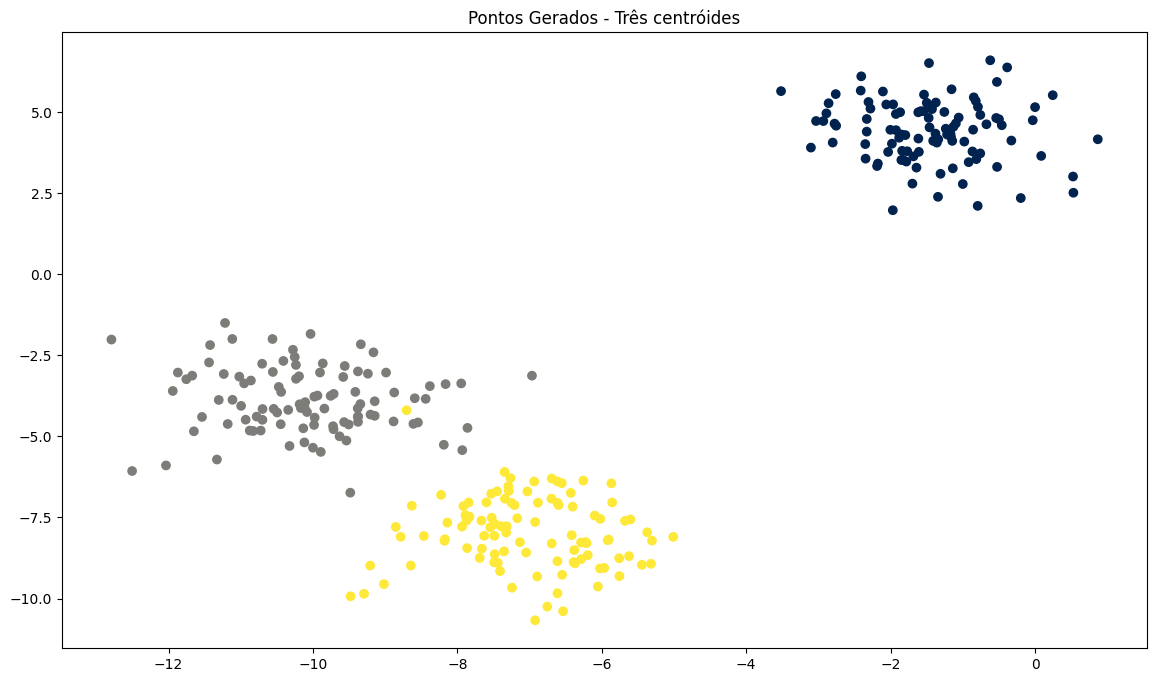

In [28]:
# Definindo uma amostra com três centróides
tam = 300

# Gerando dados aleatórios para o exemplo
elementos_blobs3, classes_blobs3 = make_blobs(n_samples=300, centers=3, random_state=1)
df_blobs3 = DataFrame(dict(x=elementos_blobs3[:,0], y=elementos_blobs3[:,1], classe=classes_blobs3))
setattr(df_blobs3, 'titulo', 'Três centróides')

# Plotando os pontos gerados
plot_pontos(df_blobs3)
# Plotando os grupos esperados
plot_pontos(df_blobs3, classes_blobs3)

### Datasets Sintéticos - IGN

#### Amostra com duas meias-luas intercalados

17:48:29 - Início do cálculo da matriz de distancias
17:48:29 - Término do cálculo da matriz de distancias
17:48:29 - Término da geração da Árvore Geradora Mínima
17:48:29 - Término da geração das arestas
17:48:29 - Término do cálculo do custo


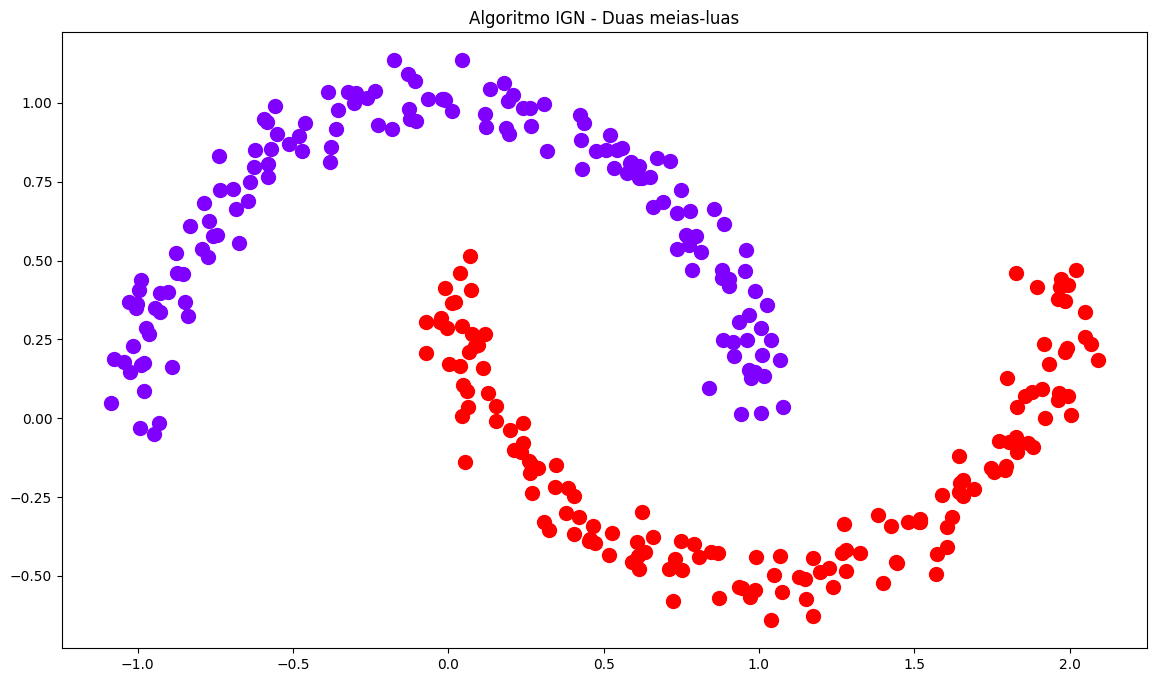


Quantidade de elementos em cada grupo (components):
Grupo 0: 150 elementos
Grupo 1: 150 elementos


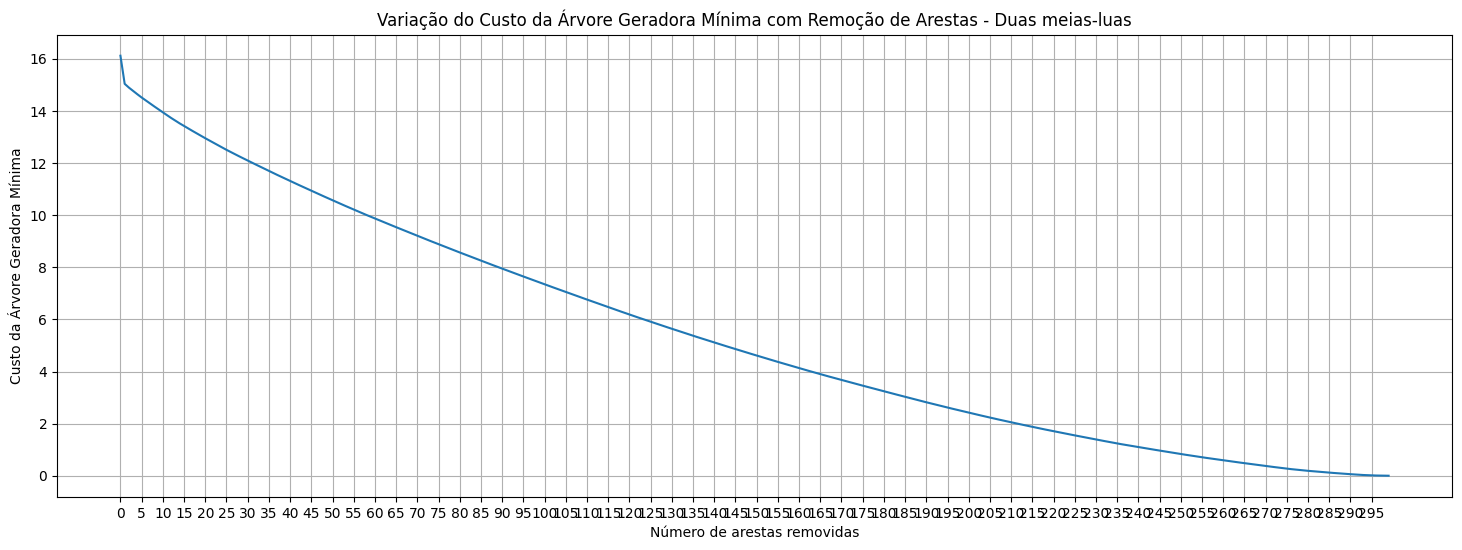


Custo da Árvore Geradora Mínima: 15.042512297015111

Grupos identificados: 2

Tempo de execução: 0.7779793739318848 segundos


In [29]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_moons)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com dois circulos concêntricos

17:48:30 - Início do cálculo da matriz de distancias
17:48:30 - Término do cálculo da matriz de distancias
17:48:30 - Término da geração da Árvore Geradora Mínima
17:48:30 - Término da geração das arestas
17:48:30 - Término do cálculo do custo


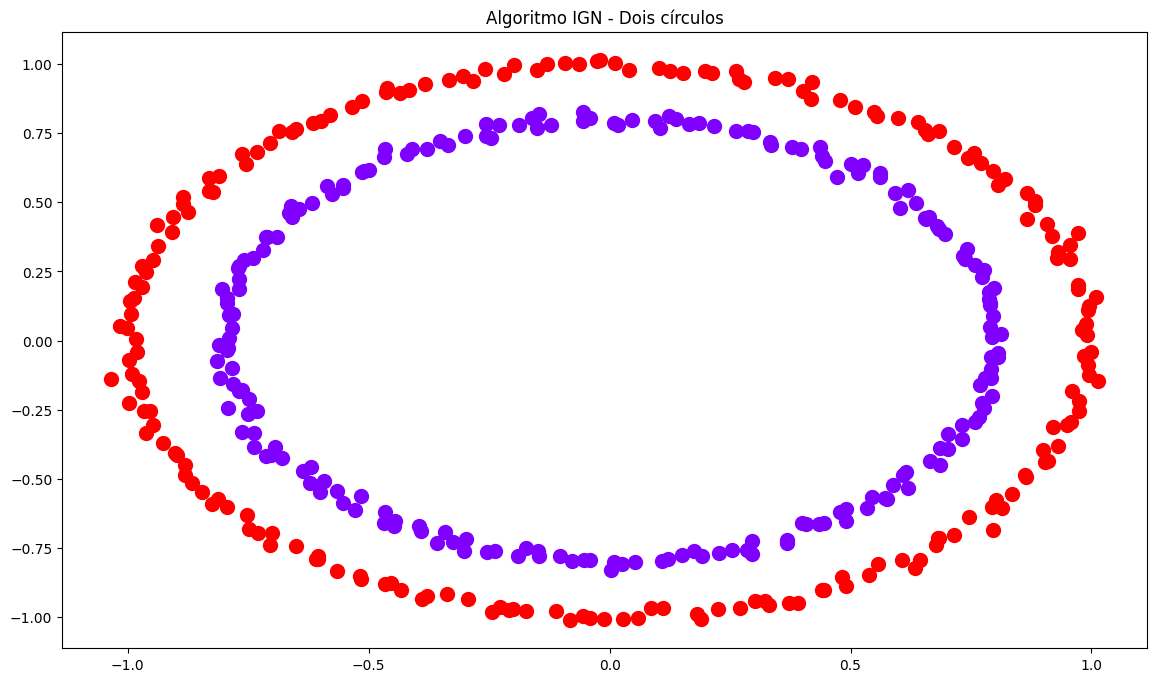


Quantidade de elementos em cada grupo (components):
Grupo 0: 200 elementos
Grupo 1: 200 elementos


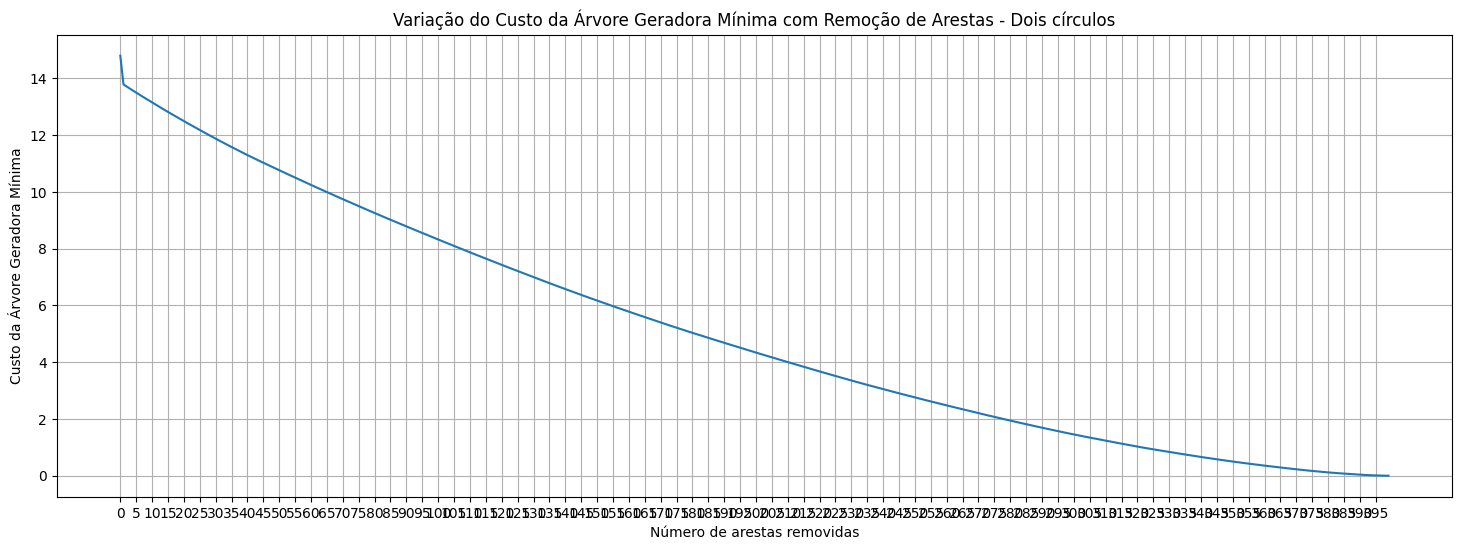


Custo da Árvore Geradora Mínima: 13.787053719848053

Grupos identificados: 2

Tempo de execução: 0.9232347011566162 segundos


In [30]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_circles)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com duas classes

17:48:31 - Início do cálculo da matriz de distancias
17:48:31 - Término do cálculo da matriz de distancias
17:48:31 - Término da geração da Árvore Geradora Mínima
17:48:31 - Término da geração das arestas
17:48:31 - Término do cálculo do custo


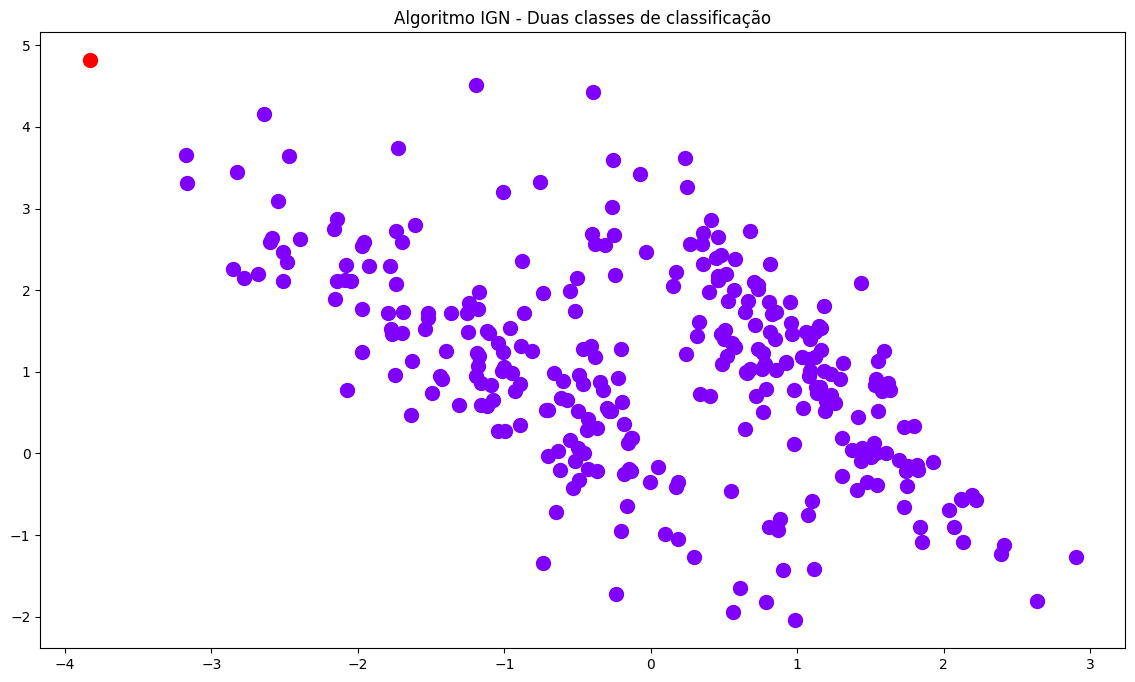


Quantidade de elementos em cada grupo (components):
Grupo 0: 299 elementos
Grupo 1: 1 elementos


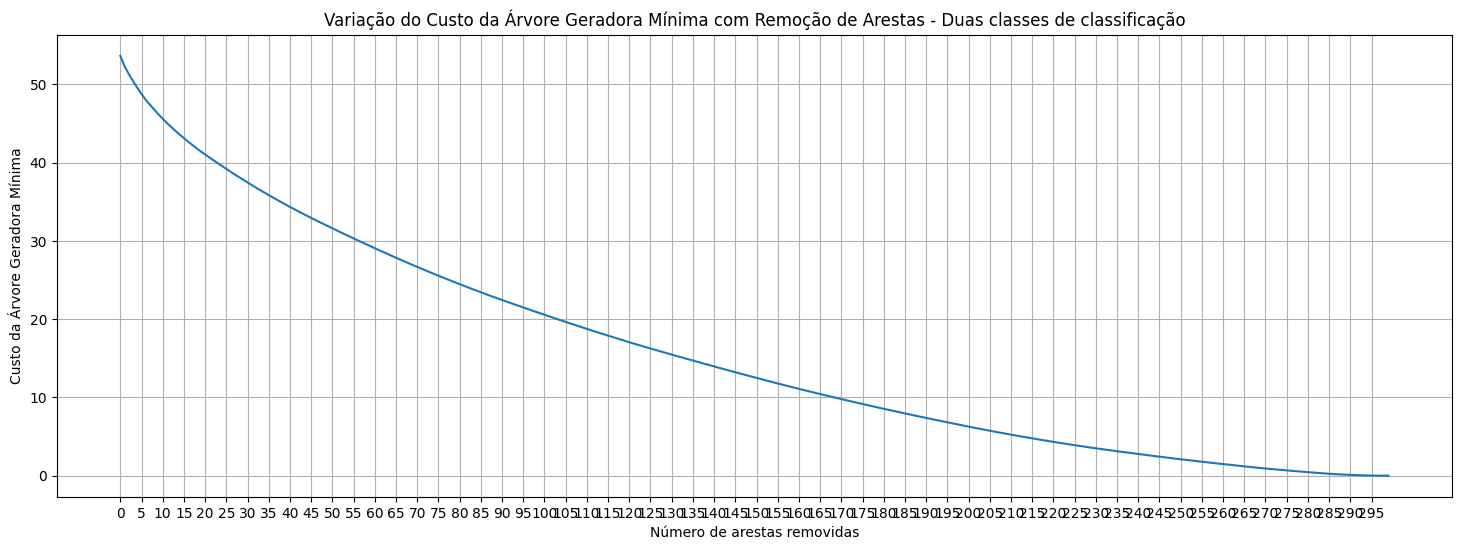


Custo da Árvore Geradora Mínima: 52.33058041614042

Grupos identificados: 2

Tempo de execução: 0.978813886642456 segundos


In [31]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_classification)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com duas classes com poda

17:48:32 - Início do cálculo da matriz de distancias
17:48:32 - Término do cálculo da matriz de distancias
17:48:32 - Término da geração da Árvore Geradora Mínima
17:48:32 - Término da geração das arestas
17:48:32 - Término do cálculo do custo


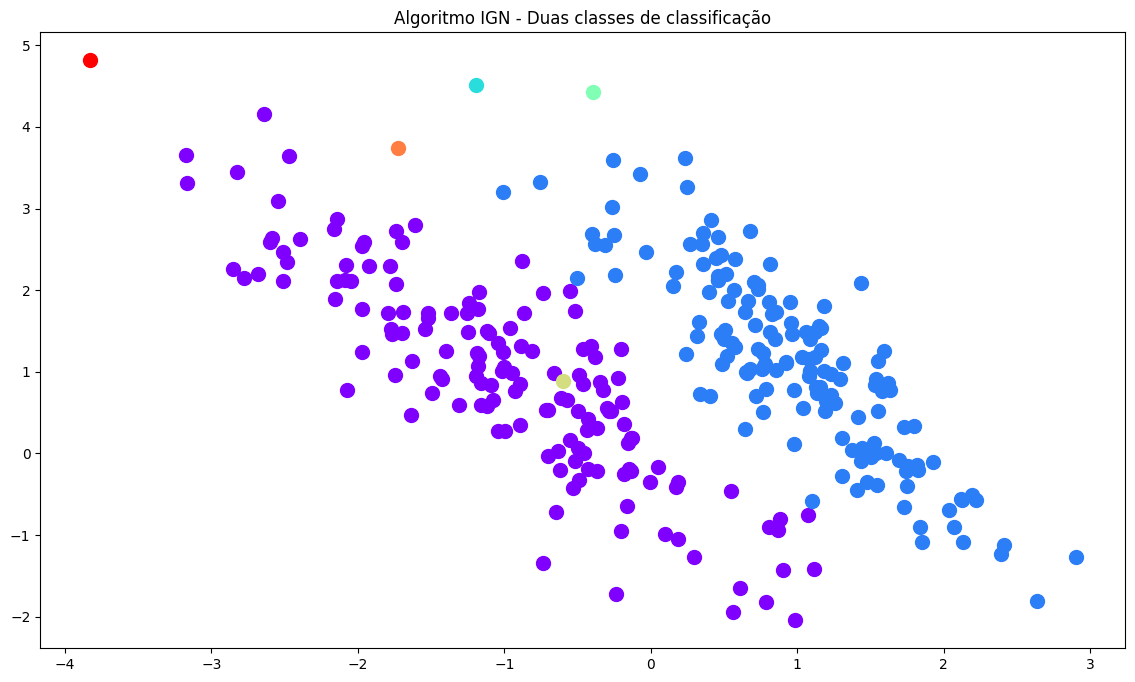


Quantidade de elementos em cada grupo (components):
Grupo 0: 147 elementos
Grupo 1: 148 elementos
Grupo 2: 1 elementos
Grupo 3: 1 elementos
Grupo 4: 1 elementos
Grupo 5: 1 elementos
Grupo 6: 1 elementos


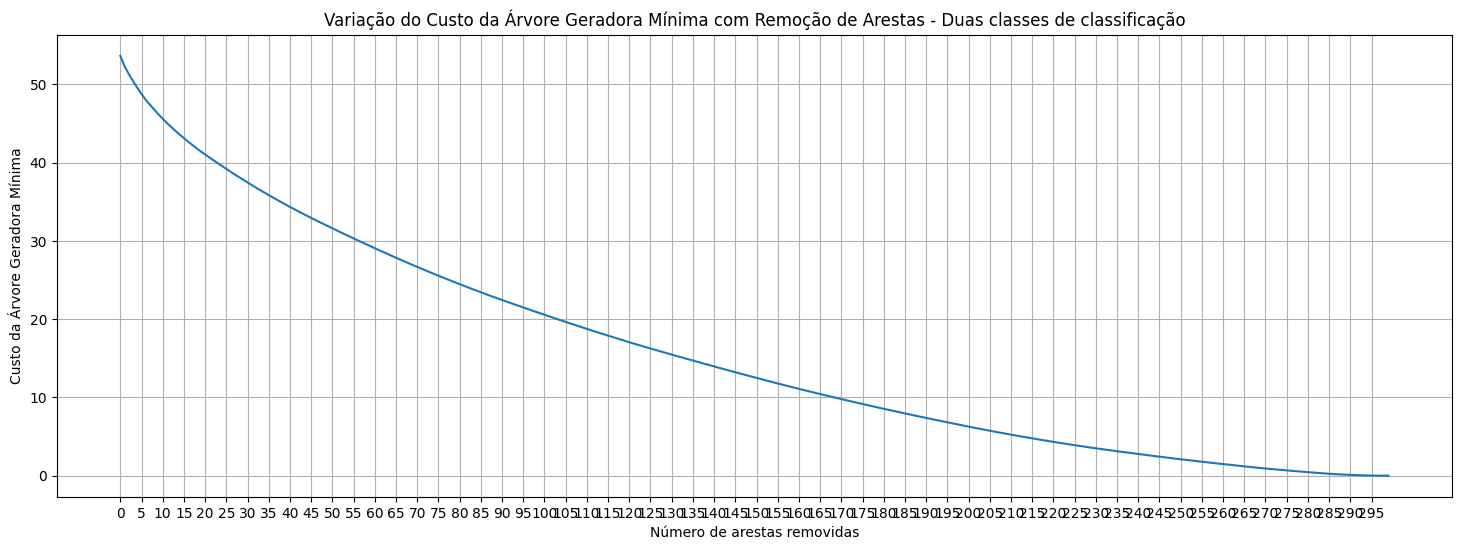


Custo da Árvore Geradora Mínima: 48.02700098441937

Grupos identificados: 7

Tempo de execução: 1.3653559684753418 segundos


In [32]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_classification, min_grupo=3)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com dois centróides

17:48:33 - Início do cálculo da matriz de distancias
17:48:33 - Término do cálculo da matriz de distancias
17:48:33 - Término da geração da Árvore Geradora Mínima
17:48:33 - Término da geração das arestas
17:48:33 - Término do cálculo do custo


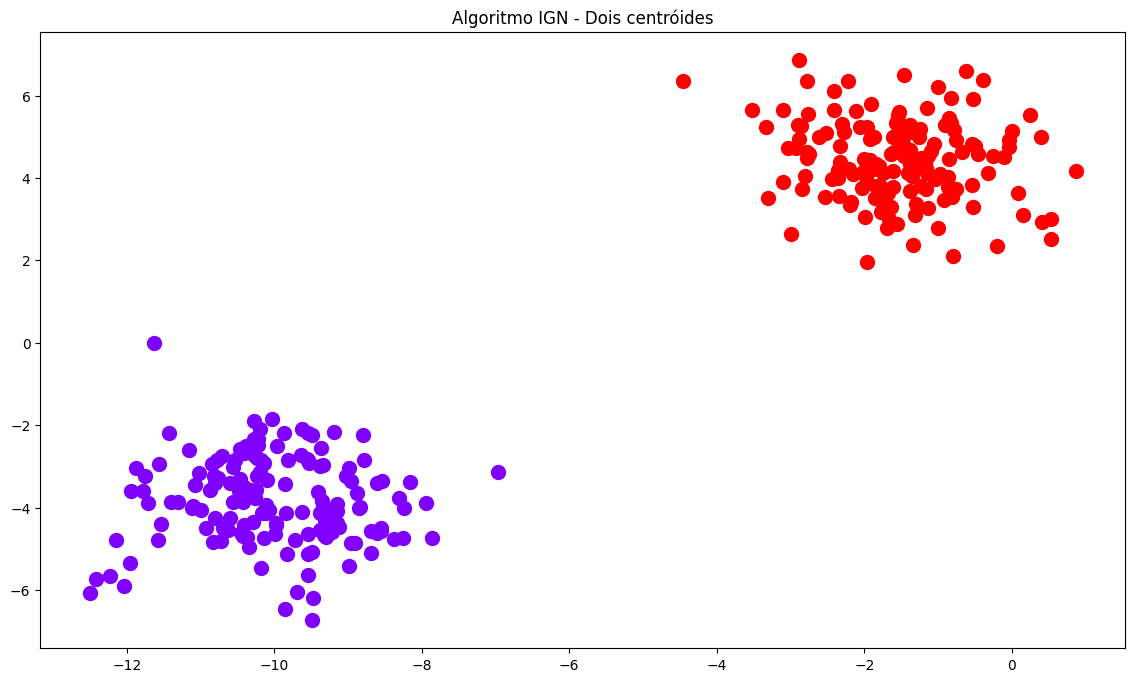


Quantidade de elementos em cada grupo (components):
Grupo 0: 150 elementos
Grupo 1: 150 elementos


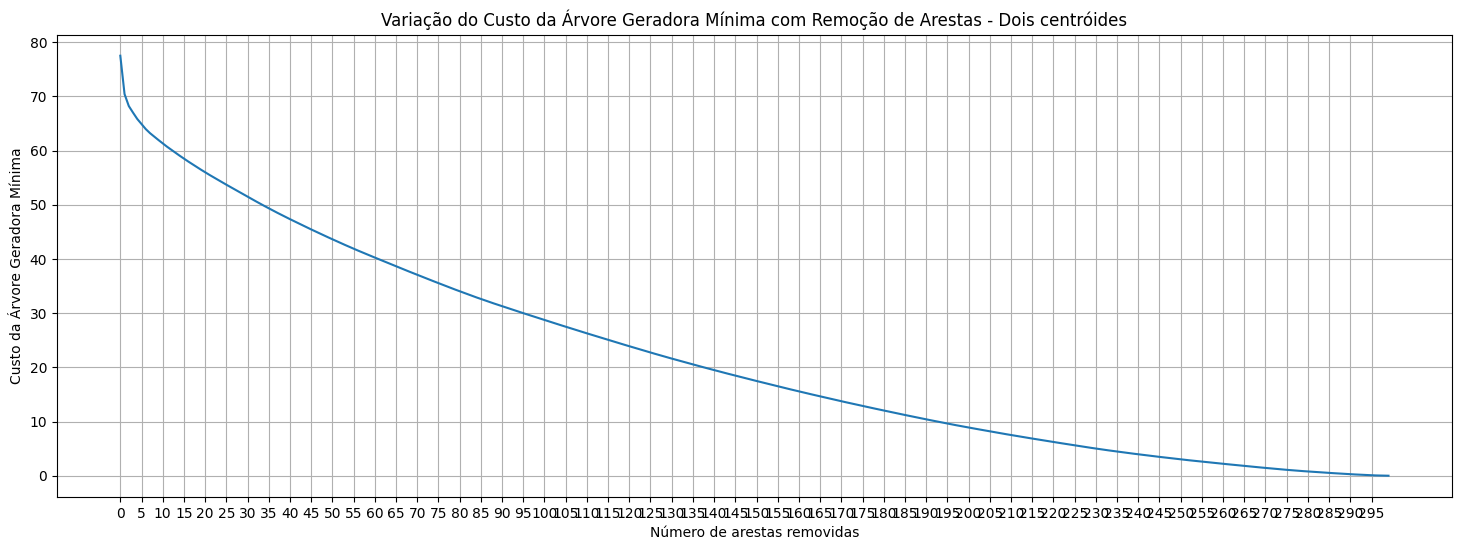


Custo da Árvore Geradora Mínima: 70.42271895191254

Grupos identificados: 2

Tempo de execução: 1.1055536270141602 segundos


In [33]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_blobs)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com três centróides

17:48:34 - Início do cálculo da matriz de distancias
17:48:34 - Término do cálculo da matriz de distancias
17:48:34 - Término da geração da Árvore Geradora Mínima
17:48:34 - Término da geração das arestas
17:48:34 - Término do cálculo do custo


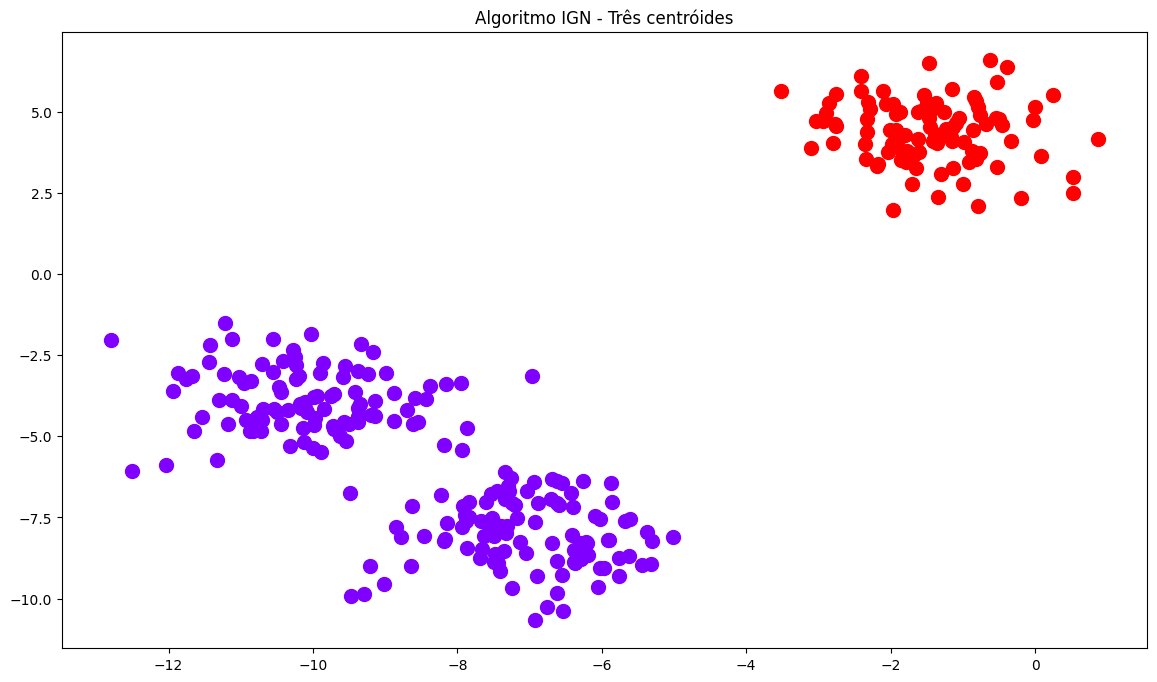


Quantidade de elementos em cada grupo (components):
Grupo 0: 200 elementos
Grupo 1: 100 elementos


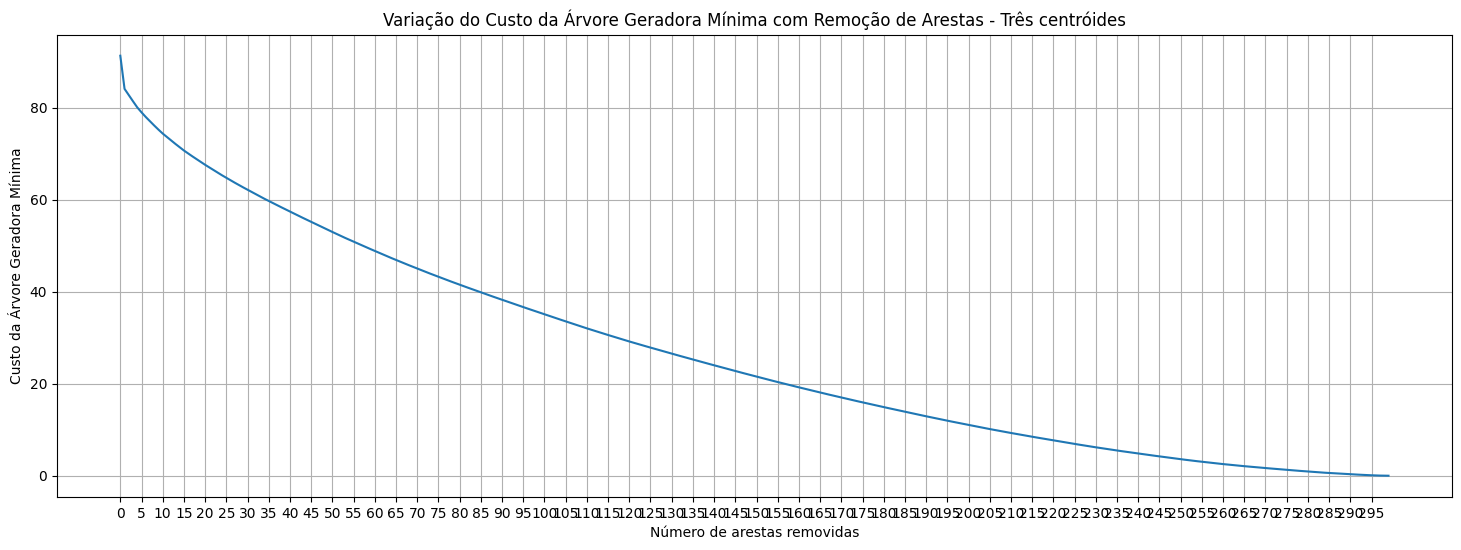


Custo da Árvore Geradora Mínima: 84.13410853975404

Grupos identificados: 2

Tempo de execução: 1.0257787704467773 segundos


In [34]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_blobs3)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com três centróides com poda

17:48:35 - Início do cálculo da matriz de distancias
17:48:35 - Término do cálculo da matriz de distancias
17:48:36 - Término da geração da Árvore Geradora Mínima
17:48:36 - Término da geração das arestas
17:48:36 - Término do cálculo do custo


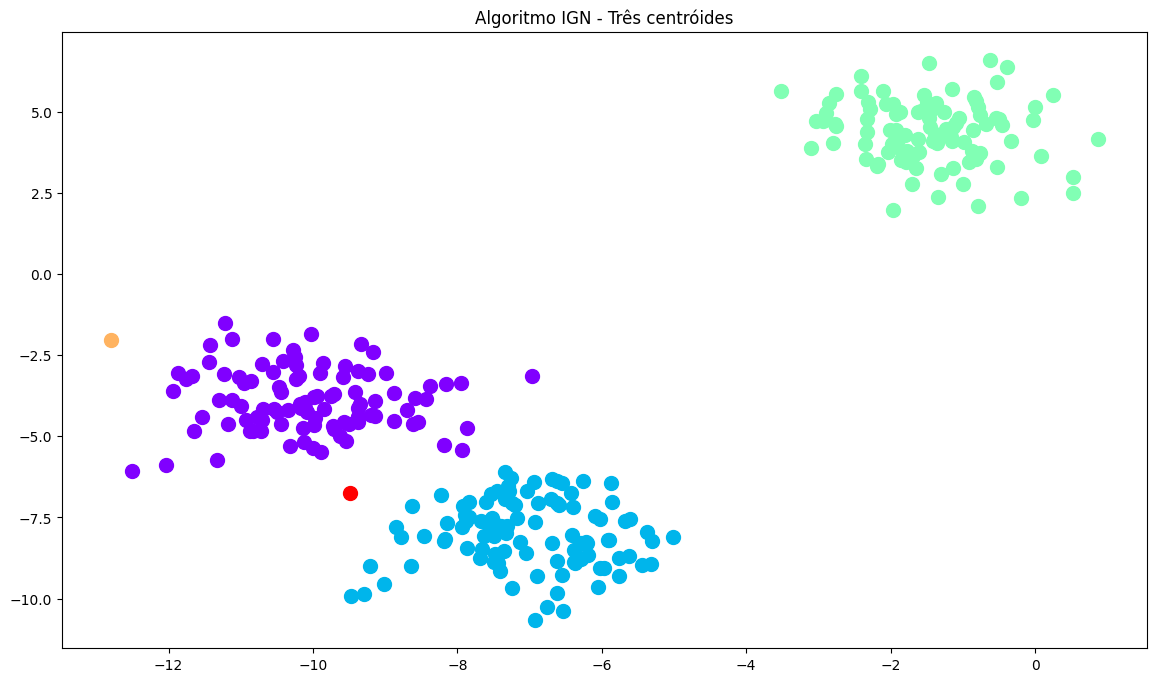


Quantidade de elementos em cada grupo (components):
Grupo 0: 99 elementos
Grupo 1: 99 elementos
Grupo 2: 100 elementos
Grupo 3: 1 elementos
Grupo 4: 1 elementos


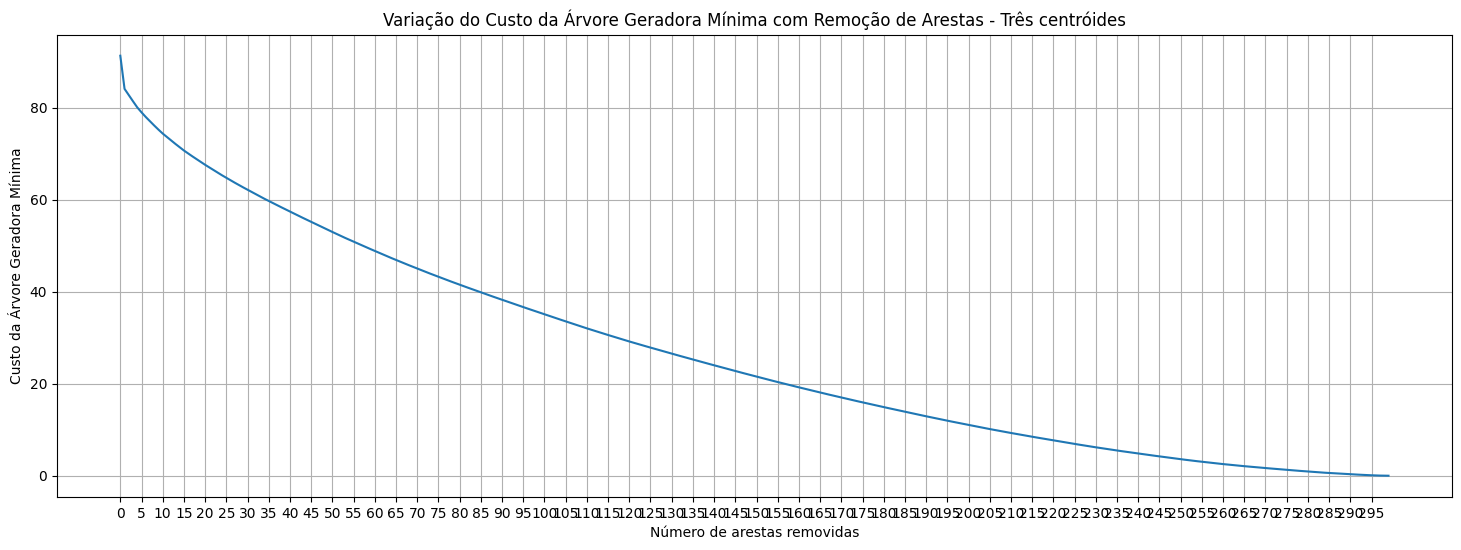


Custo da Árvore Geradora Mínima: 80.10150856747123

Grupos identificados: 5

Tempo de execução: 0.7843520641326904 segundos


In [35]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ign(df_blobs3, min_grupo=3)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

### Datasets Sintéticos - IGN Modificado

#### Amostra com duas meias-luas intercalados

17:48:36 - Início do cálculo da matriz de distancias
17:48:36 - Término do cálculo da matriz de distancias
17:48:36 - Término da geração da Árvore Geradora Mínima
17:48:36 - Término da geração das arestas
17:48:36 - Término do cálculo do custo
n_alvo:  1
total_elementos:  300
grupos_counter:  Counter({0: 150, 1: 150})


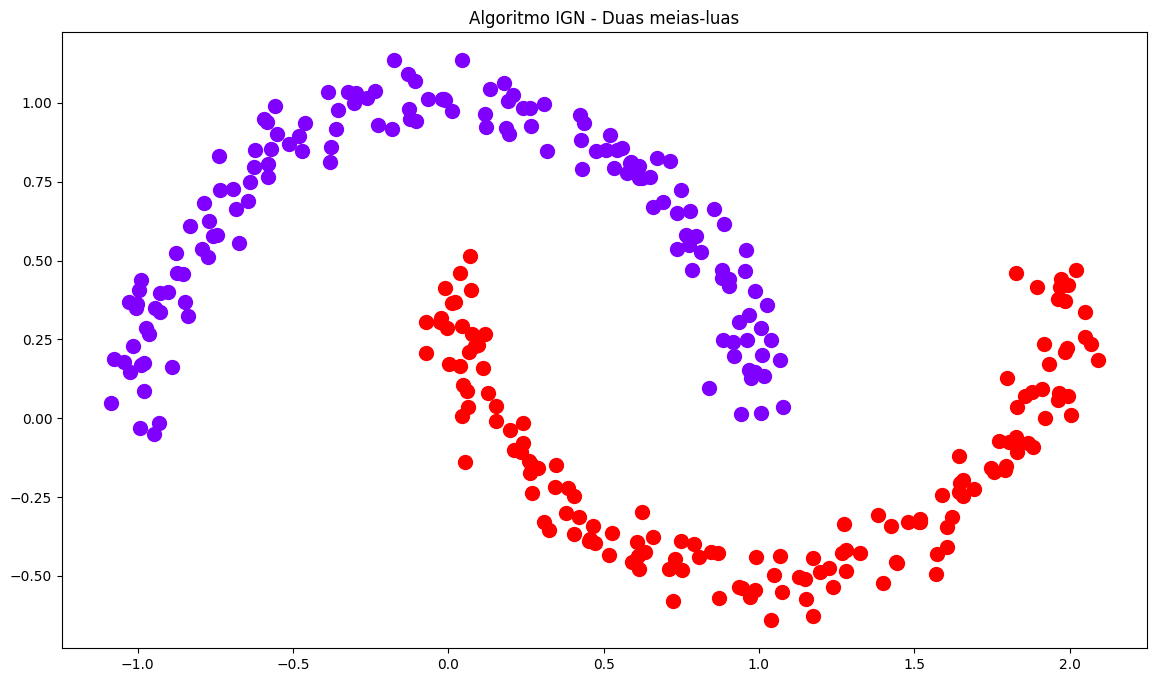


Quantidade de elementos em cada grupo (components):
Grupo 0: 150 elementos
Grupo 1: 150 elementos


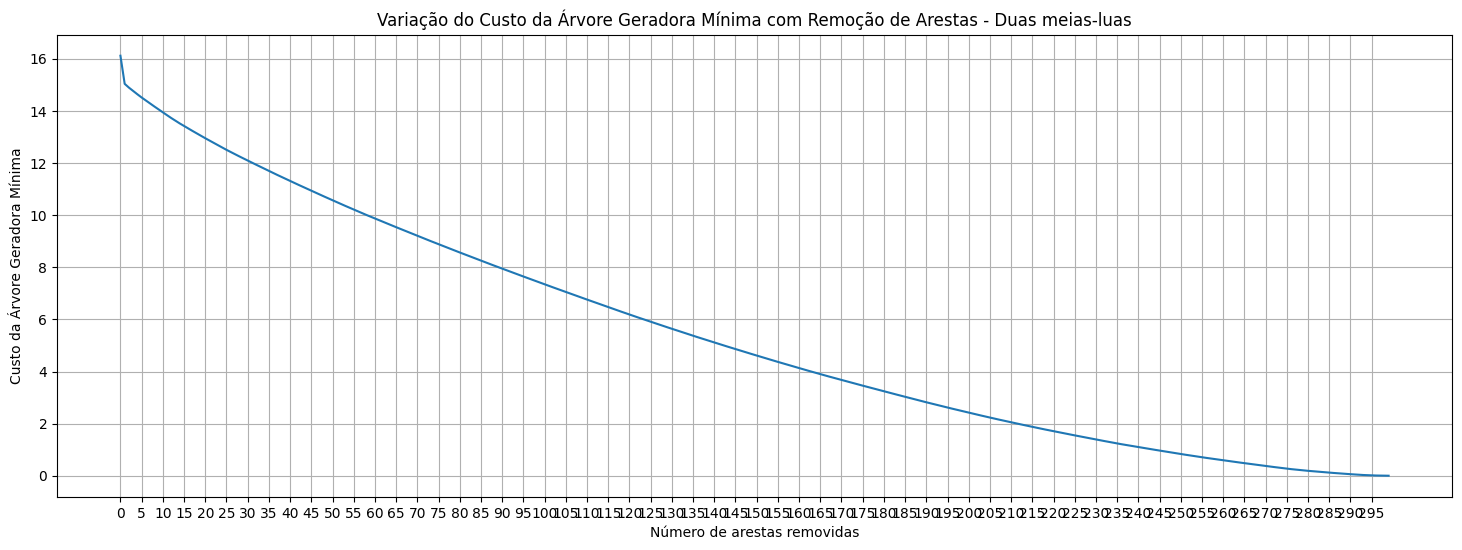


Custo da Árvore Geradora Mínima: 15.042512297015111

Grupos identificados: 2

Tempo de execução: 0.7679314613342285 segundos


In [36]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(df_moons, percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com dois circulos concêntricos

17:48:37 - Início do cálculo da matriz de distancias
17:48:37 - Término do cálculo da matriz de distancias
17:48:37 - Término da geração da Árvore Geradora Mínima
17:48:37 - Término da geração das arestas
17:48:37 - Término do cálculo do custo
n_alvo:  1
total_elementos:  400
grupos_counter:  Counter({0: 200, 1: 200})


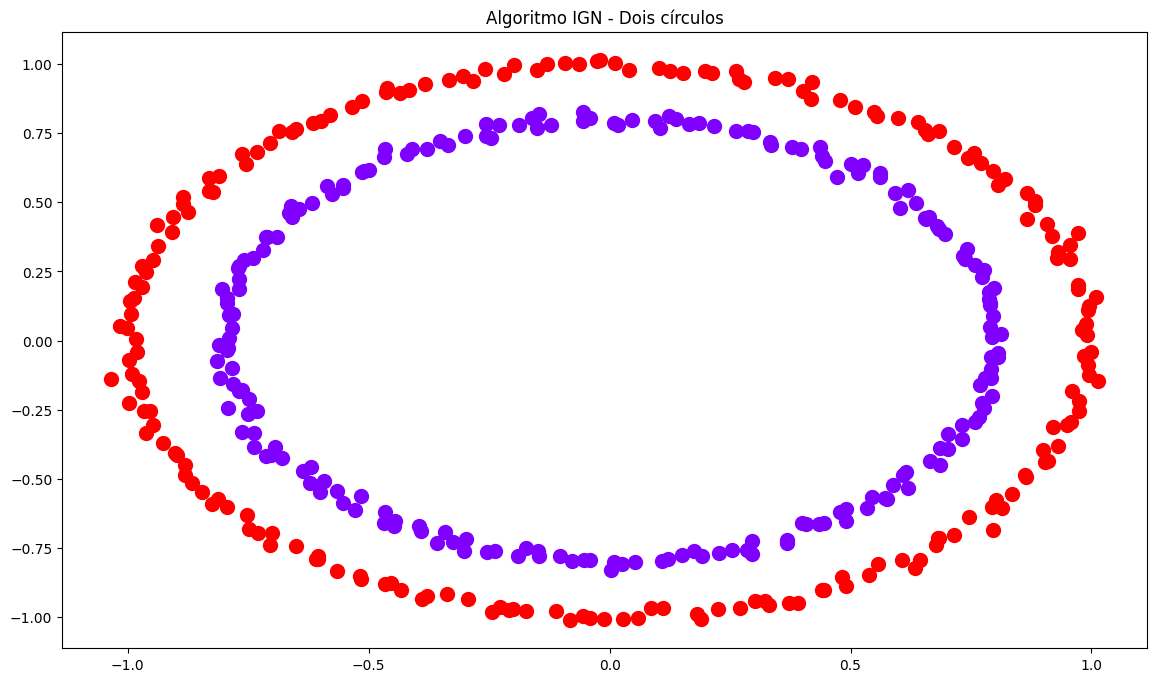


Quantidade de elementos em cada grupo (components):
Grupo 0: 200 elementos
Grupo 1: 200 elementos


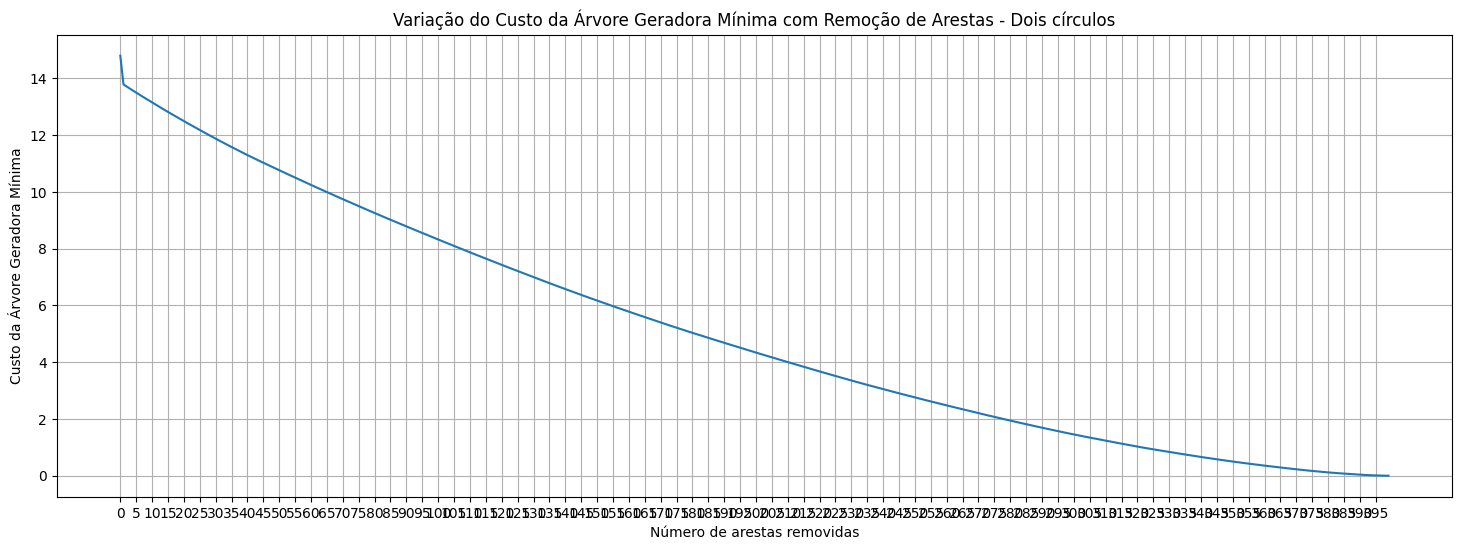


Custo da Árvore Geradora Mínima: 13.787053719848053

Grupos identificados: 2

Tempo de execução: 1.1215901374816895 segundos


In [37]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(df_circles, percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com duas classes

17:48:38 - Início do cálculo da matriz de distancias
17:48:38 - Término do cálculo da matriz de distancias
17:48:38 - Término da geração da Árvore Geradora Mínima
17:48:38 - Término da geração das arestas
17:48:38 - Término do cálculo do custo
n_alvo:  1
total_elementos:  300
grupos_counter:  Counter({0: 299, 1: 1})
grupo:  0
tamanho:  299
17:48:38 - Início do cálculo da matriz de distancias
17:48:38 - Término do cálculo da matriz de distancias
17:48:38 - Término da geração da Árvore Geradora Mínima
17:48:38 - Término da geração das arestas
17:48:38 - Término do cálculo do custo
n_alvo:  5
grupos_counter:  Counter({3: 148, 2: 147, 4: 1, 5: 1, 6: 1, 7: 1, 1: 1})


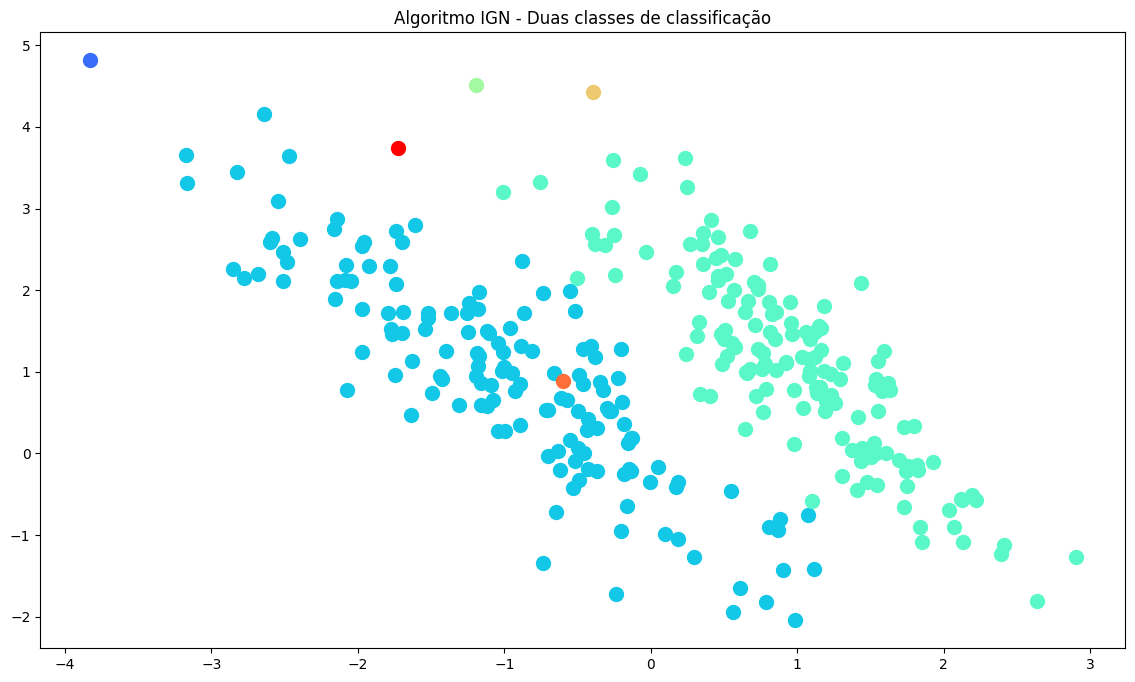


Quantidade de elementos em cada grupo (components):
Grupo 1: 1 elementos
Grupo 2: 147 elementos
Grupo 3: 148 elementos
Grupo 4: 1 elementos
Grupo 5: 1 elementos
Grupo 6: 1 elementos
Grupo 7: 1 elementos


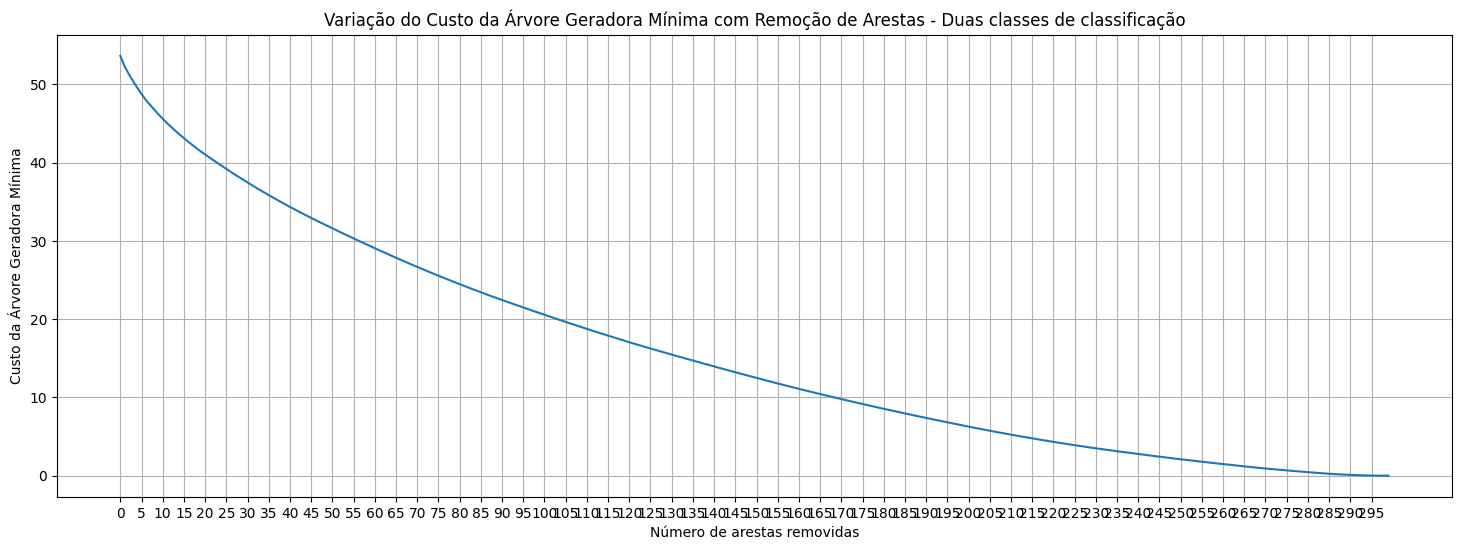


Custo da Árvore Geradora Mínima: 52.33058041614042

Grupos identificados: 7

Tempo de execução: 0.8723602294921875 segundos


In [38]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(df_classification, percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com dois centróides

17:48:39 - Início do cálculo da matriz de distancias
17:48:39 - Término do cálculo da matriz de distancias
17:48:39 - Término da geração da Árvore Geradora Mínima
17:48:39 - Término da geração das arestas
17:48:39 - Término do cálculo do custo
n_alvo:  1
total_elementos:  300
grupos_counter:  Counter({0: 150, 1: 150})


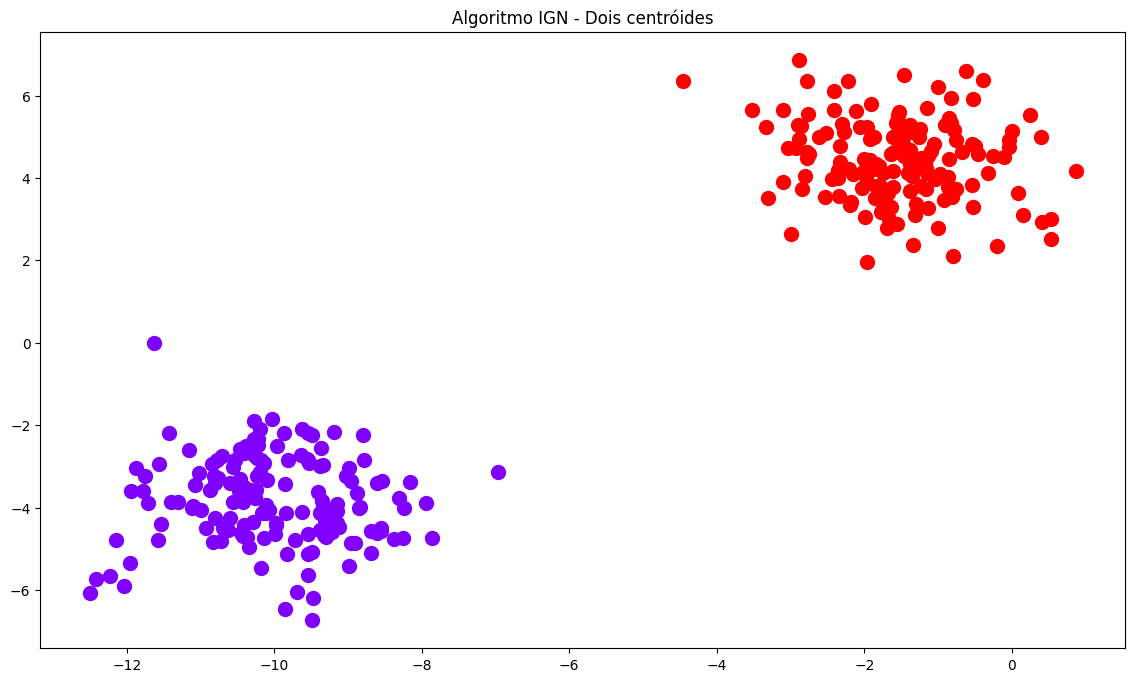


Quantidade de elementos em cada grupo (components):
Grupo 0: 150 elementos
Grupo 1: 150 elementos


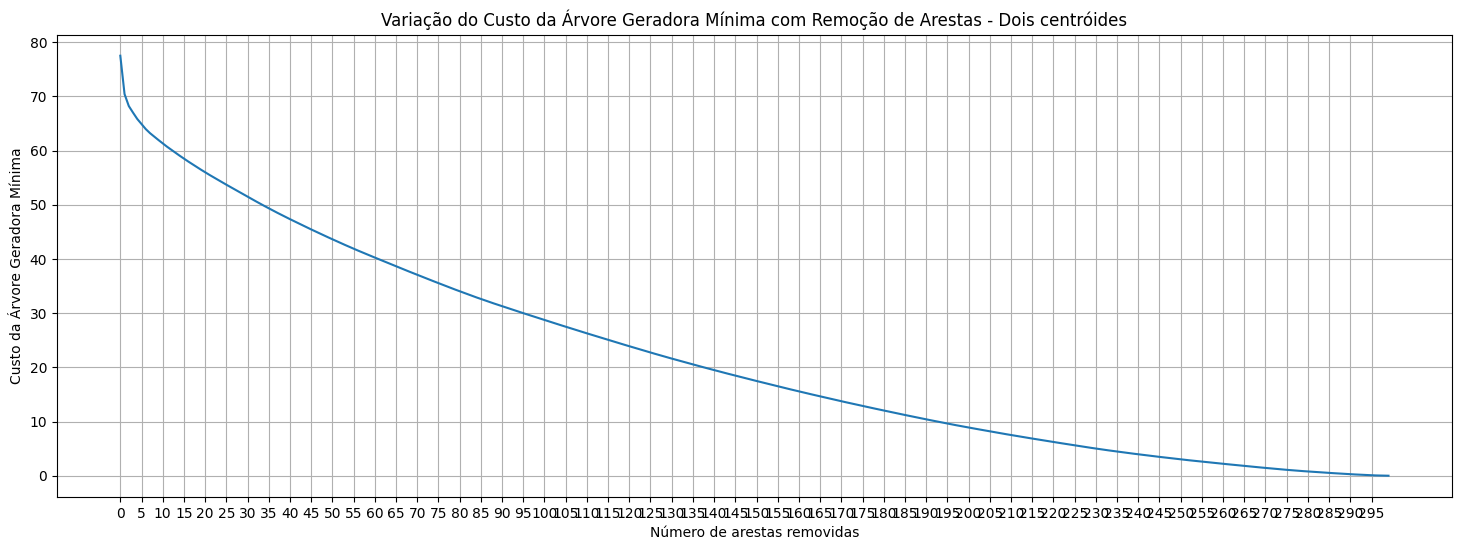


Custo da Árvore Geradora Mínima: 70.42271895191254

Grupos identificados: 2

Tempo de execução: 0.8036656379699707 segundos


In [39]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(df_blobs, percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

#### Amostra com três centróides

17:48:40 - Início do cálculo da matriz de distancias
17:48:40 - Término do cálculo da matriz de distancias
17:48:40 - Término da geração da Árvore Geradora Mínima
17:48:40 - Término da geração das arestas
17:48:40 - Término do cálculo do custo
n_alvo:  1
total_elementos:  300
grupos_counter:  Counter({0: 200, 1: 100})
grupo:  0
tamanho:  200
17:48:40 - Início do cálculo da matriz de distancias
17:48:40 - Término do cálculo da matriz de distancias
17:48:40 - Término da geração da Árvore Geradora Mínima
17:48:40 - Término da geração das arestas
17:48:40 - Término do cálculo do custo
n_alvo:  3
grupos_counter:  Counter({1: 100, 2: 99, 3: 99, 4: 1, 5: 1})


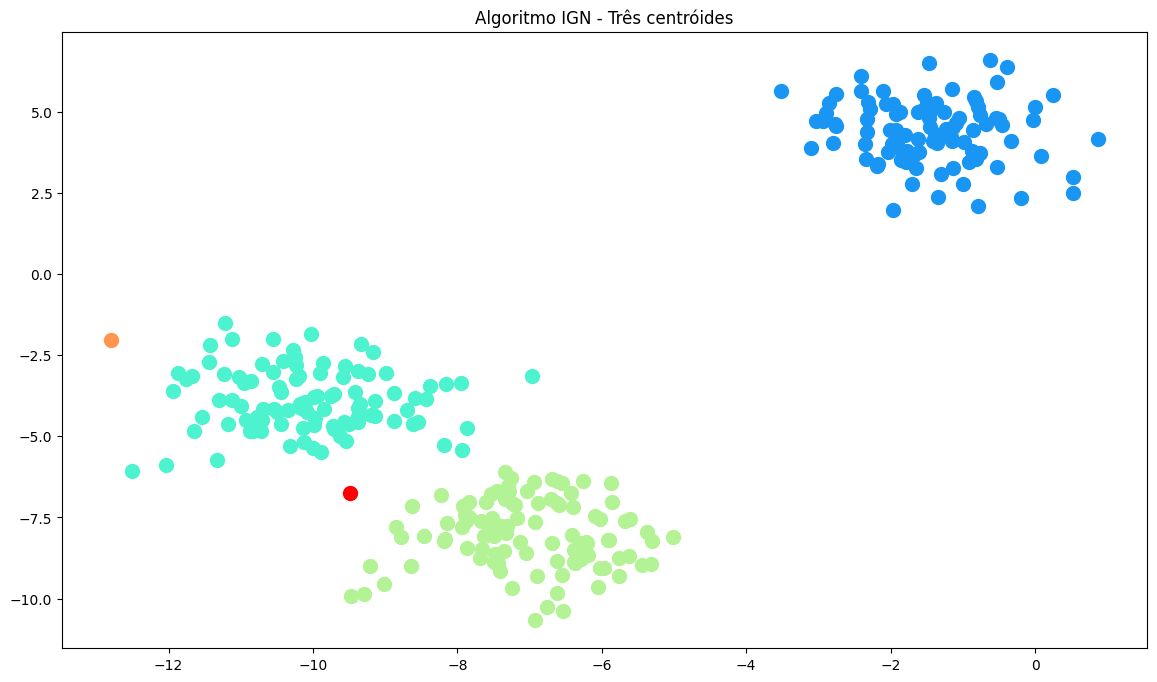


Quantidade de elementos em cada grupo (components):
Grupo 1: 100 elementos
Grupo 2: 99 elementos
Grupo 3: 99 elementos
Grupo 4: 1 elementos
Grupo 5: 1 elementos


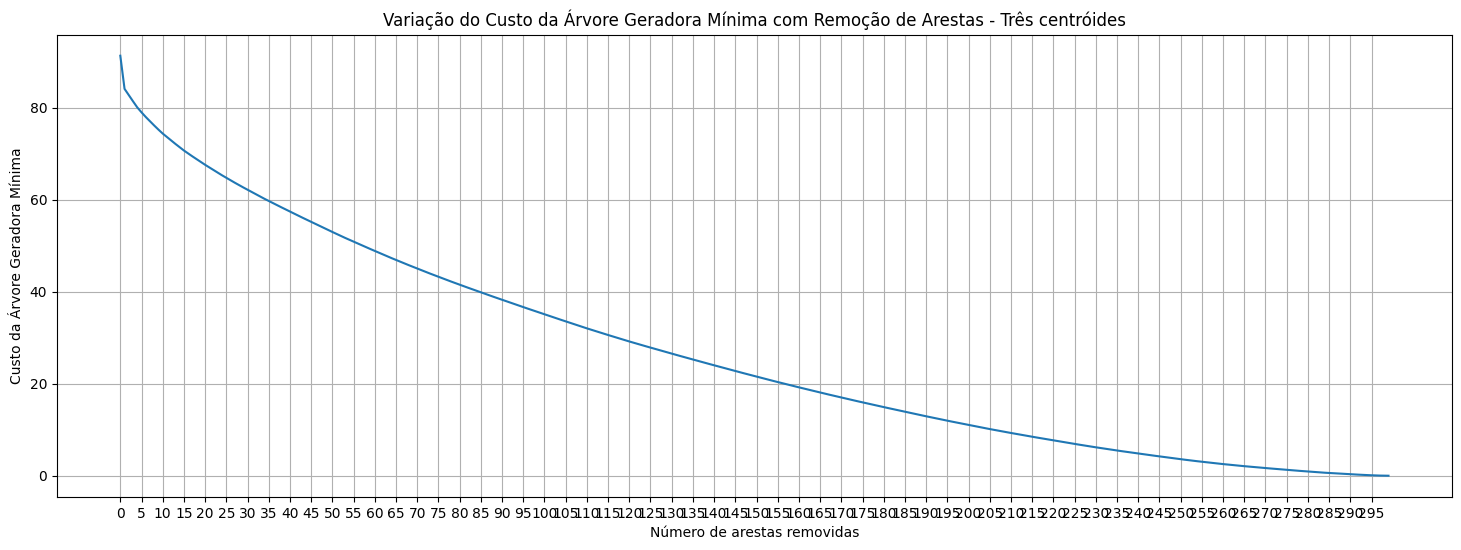


Custo da Árvore Geradora Mínima: 84.13410853975404

Grupos identificados: 5

Tempo de execução: 0.8173401355743408 segundos


In [40]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
ignModificado(df_blobs3, percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

## Íris

### Dataset Iris - Definição

In [41]:
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
setattr(df_iris, 'titulo', 'Flor de Íris')

In [42]:
df_iris.values.shape

(150, 4)

In [43]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [44]:
df_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [45]:
iris_counts = {label: count for label, count in zip(*np.unique(iris.target, return_counts=True))}

print("Quantidade de elementos em cada grupo (iris.target):")
for label, count in iris_counts.items():
    print(f"Grupo {label}: {count} elementos")

Quantidade de elementos em cada grupo (iris.target):
Grupo 0: 50 elementos
Grupo 1: 50 elementos
Grupo 2: 50 elementos


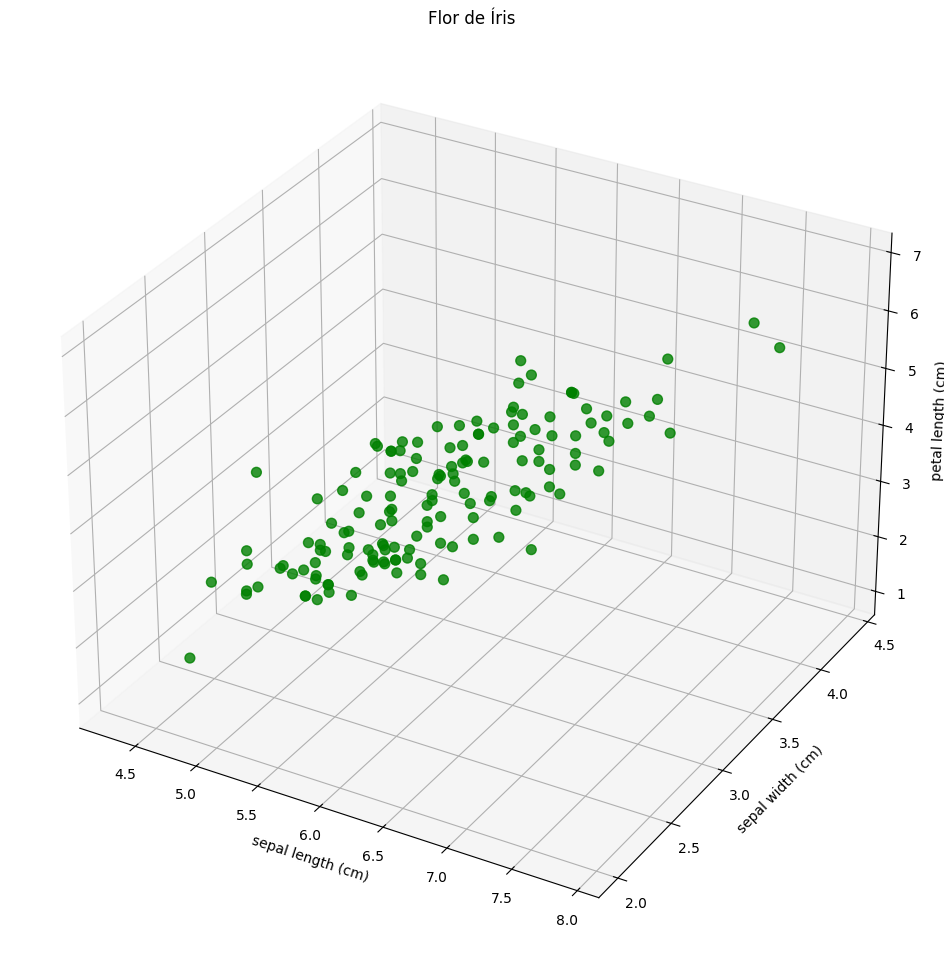

In [46]:
plot_pontos3D(df_iris)

Quantidade por grupo:
Grupo 0: 50 elementos
Grupo 1: 50 elementos
Grupo 2: 50 elementos


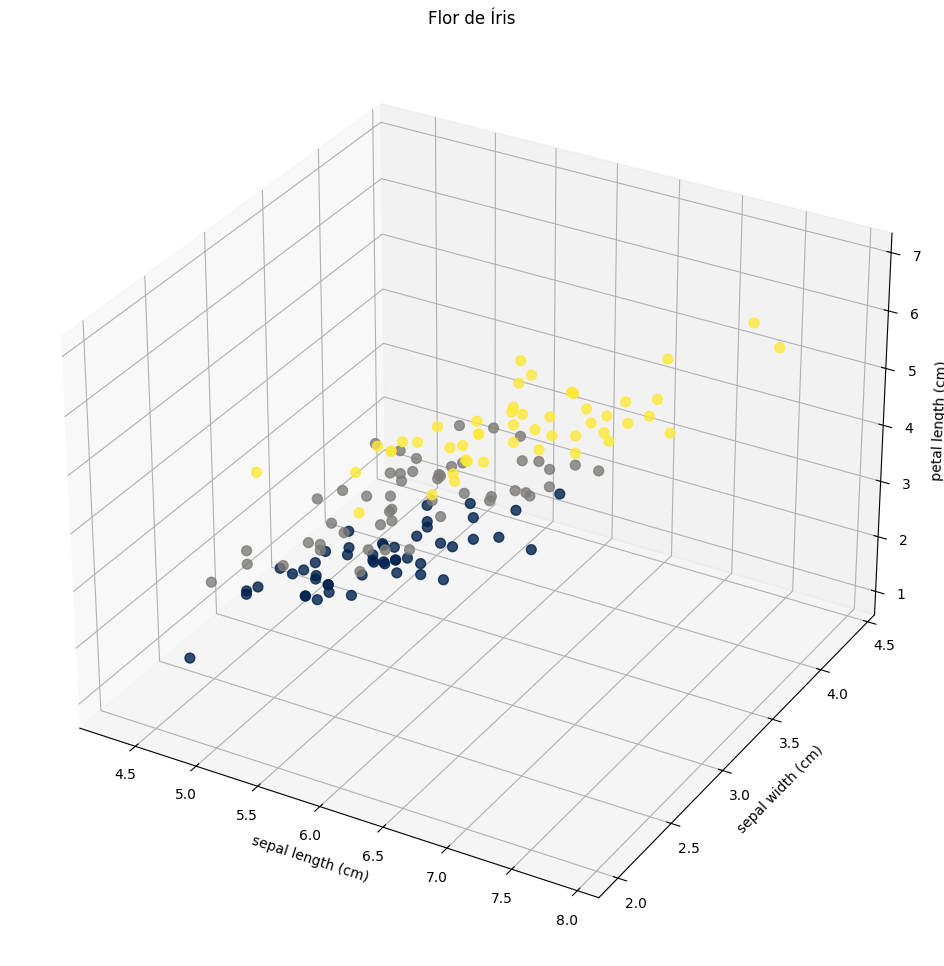

In [47]:
plot_pontos3D(df_iris, iris.target)

### Dataset Iris - IGN

17:48:42 - Início do cálculo da matriz de distancias
17:48:42 - Término do cálculo da matriz de distancias
17:48:42 - Término da geração da Árvore Geradora Mínima
17:48:42 - Término da geração das arestas
17:48:42 - Término do cálculo do custo


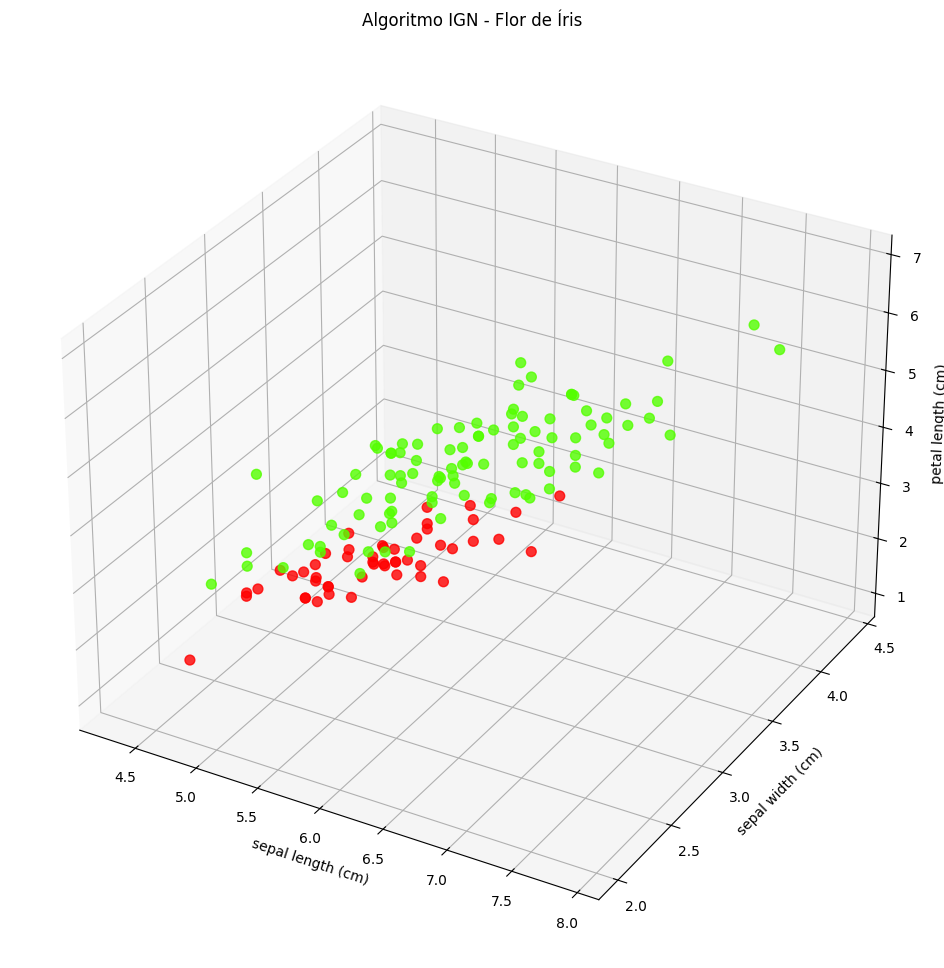


Quantidade de elementos em cada grupo (components):
Grupo 0: 50 elementos
Grupo 1: 100 elementos


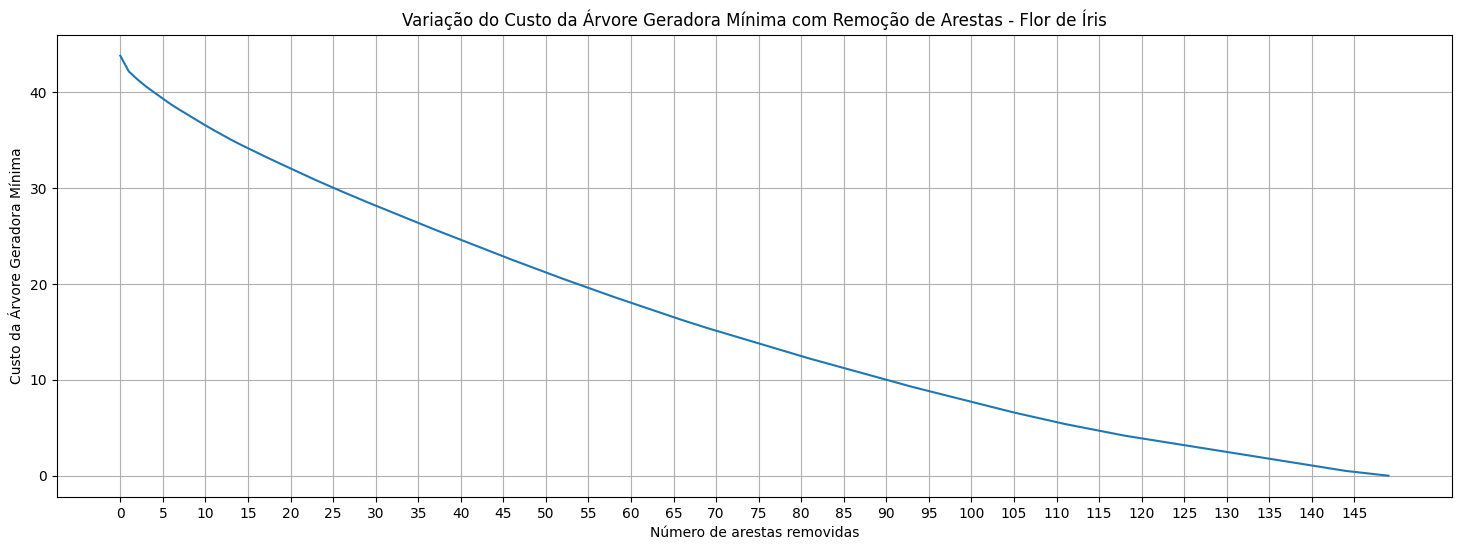


Custo da Árvore Geradora Mínima: 42.14823282271955

Grupos identificados: 2

Tempo de execução: 0.9236533641815186 segundos


In [48]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
grupos = ign(df_iris, plotAGM='3D')
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

In [49]:
df_iris['ign'] = grupos
df_iris['target'] = iris.target
esperados_iris = df_iris['target'].value_counts().rename('Esperados')

obtidos_iris_ign = df_iris.groupby(['target', 'ign']).size().unstack(fill_value=0).rename(columns=lambda x: f'Obtidos no Grupo {x}')

tabela_iris_ign = pd.concat([esperados_iris, obtidos_iris_ign], axis=1).reset_index().rename(columns={'target': 'Classe'})
print(tabela_iris_ign)

   Classe  Esperados  Obtidos no Grupo 0  Obtidos no Grupo 1
0       0         50                  50                   0
1       1         50                   0                  50
2       2         50                   0                  50


### Dataset Iris - Definição

In [50]:
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
setattr(df_iris, 'titulo', 'Flor de Íris')

### Dataset Iris - IGN Modificado

17:48:43 - Início do cálculo da matriz de distancias
17:48:43 - Término do cálculo da matriz de distancias
17:48:43 - Término da geração da Árvore Geradora Mínima
17:48:43 - Término da geração das arestas
17:48:43 - Término do cálculo do custo
n_alvo:  1
total_elementos:  150
grupos_counter:  Counter({1: 100, 0: 50})
grupo:  1
tamanho:  100
17:48:43 - Início do cálculo da matriz de distancias
17:48:43 - Término do cálculo da matriz de distancias
17:48:43 - Término da geração da Árvore Geradora Mínima
17:48:43 - Término da geração das arestas
17:48:43 - Término do cálculo do custo
n_alvo:  2
grupos_counter:  Counter({2: 97, 0: 50, 4: 2, 3: 1})
grupo:  2
tamanho:  97
17:48:43 - Início do cálculo da matriz de distancias
17:48:43 - Término do cálculo da matriz de distancias
17:48:43 - Término da geração da Árvore Geradora Mínima
17:48:43 - Término da geração das arestas
17:48:43 - Término do cálculo do custo
n_alvo:  2
grupos_counter:  Counter({5: 92, 0: 50, 6: 4, 4: 2, 3: 1, 7: 1})
grupo:

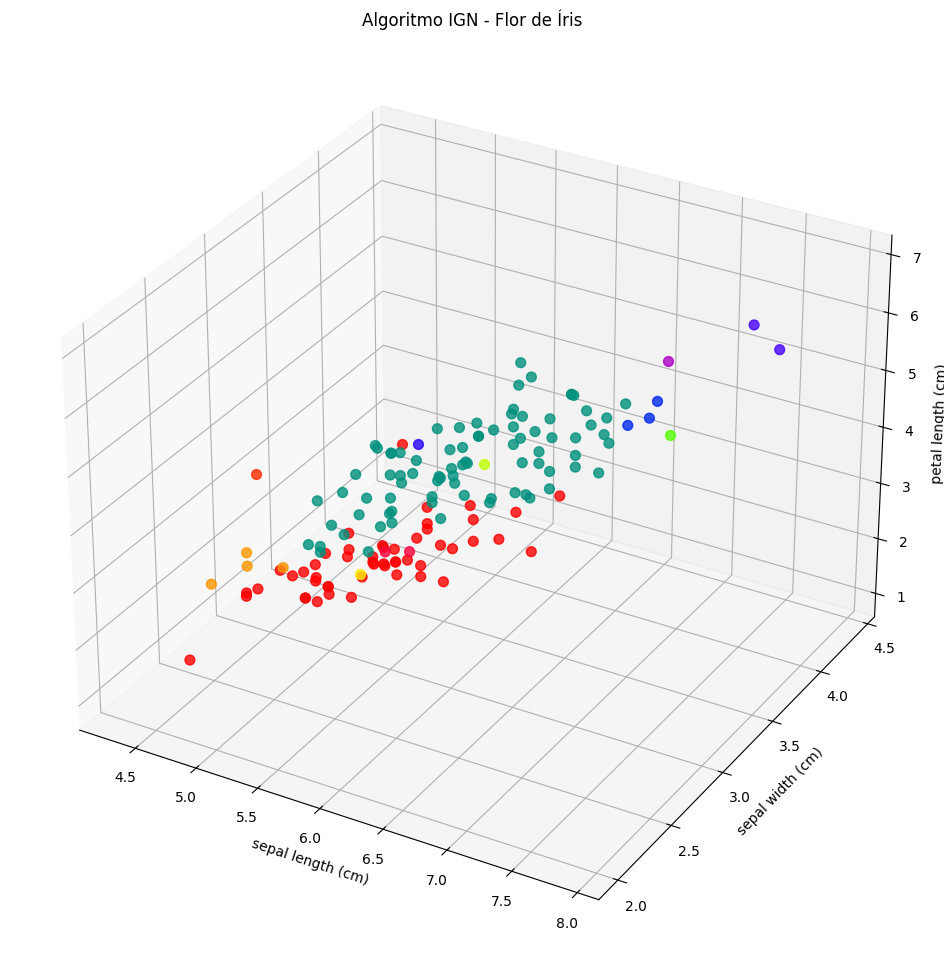


Quantidade de elementos em cada grupo (components):
Grupo 0: 50 elementos
Grupo 3: 1 elementos
Grupo 4: 2 elementos
Grupo 6: 4 elementos
Grupo 7: 1 elementos
Grupo 8: 82 elementos
Grupo 9: 1 elementos
Grupo 10: 2 elementos
Grupo 11: 3 elementos
Grupo 12: 1 elementos
Grupo 13: 1 elementos
Grupo 14: 1 elementos
Grupo 15: 1 elementos


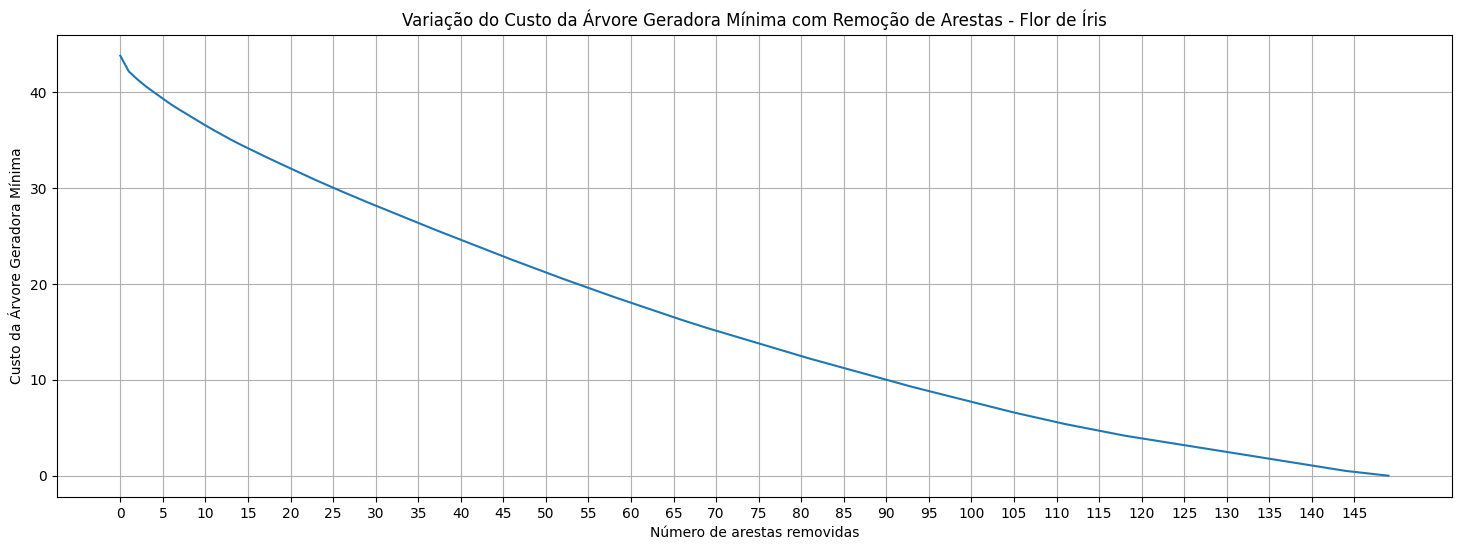


Custo da Árvore Geradora Mínima: 42.14823282271955

Grupos identificados: 13

Tempo de execução: 0.8307271003723145 segundos


In [51]:
# IGN
  # - Distância: euclidean
  # - Árvore: minimum_spanning_tree
t_inicial = time.time()
grupos_poda = ignModificado(df_iris, plotAGM='3D', percGrupo=0.6)
t_final = time.time()
print(f"Tempo de execução: {t_final - t_inicial} segundos")

In [53]:
df_iris['ign_poda'] = grupos_poda
df_iris['target'] = iris.target
esperados_iris = df_iris['target'].value_counts().rename('Esperados')

obtidos_iris_ign_poda = df_iris.groupby(['target', 'ign_poda']).size().unstack(fill_value=0).rename(columns=lambda x: f'Obtidos no Grupo {x}')

tabela_iris_ign = pd.concat([esperados_iris, obtidos_iris_ign_poda], axis=1).reset_index().rename(columns={'target': 'Classe'})
print(tabela_iris_ign)

   Classe  Esperados  Obtidos no Grupo 0  Obtidos no Grupo 3  \
0       0         50                  50                   0   
1       1         50                   0                   0   
2       2         50                   0                   1   

   Obtidos no Grupo 4  Obtidos no Grupo 6  Obtidos no Grupo 7  \
0                   0                   0                   0   
1                   0                   4                   0   
2                   2                   0                   1   

   Obtidos no Grupo 8  Obtidos no Grupo 9  Obtidos no Grupo 10  \
0                   0                   0                    0   
1                  43                   1                    2   
2                  39                   0                    0   

   Obtidos no Grupo 11  Obtidos no Grupo 12  Obtidos no Grupo 13  \
0                    0                    0                    0   
1                    0                    0                    0   
2            